# 몬테카를로 베이지안 분석

## Rejection Sampling

당장 샘플링 가능한 유사 확률분포를 사용하여 목표 확률분포의 샘플을 생성

* $p(x)$: 샘플링하고자 하는 목표 확률분포
* $q(x)$: 샘플링 가능한 유사 확률분포
* $k$: $kq(x) \geq p(x)$가 되도록 하는 스케일링 상수

> $p(z)/kq(z)$의 확률로 $q(x)$의 샘플을 채택

<img src="https://datascienceschool.net/upfiles/82be070d572241ebadda0eb9f7036484.png" />

In [1]:
a = 2
b = 6
rv_p = sp.stats.beta(a, b)
rv_q = sp.stats.norm(loc=0.5, scale=0.5)
k = 5

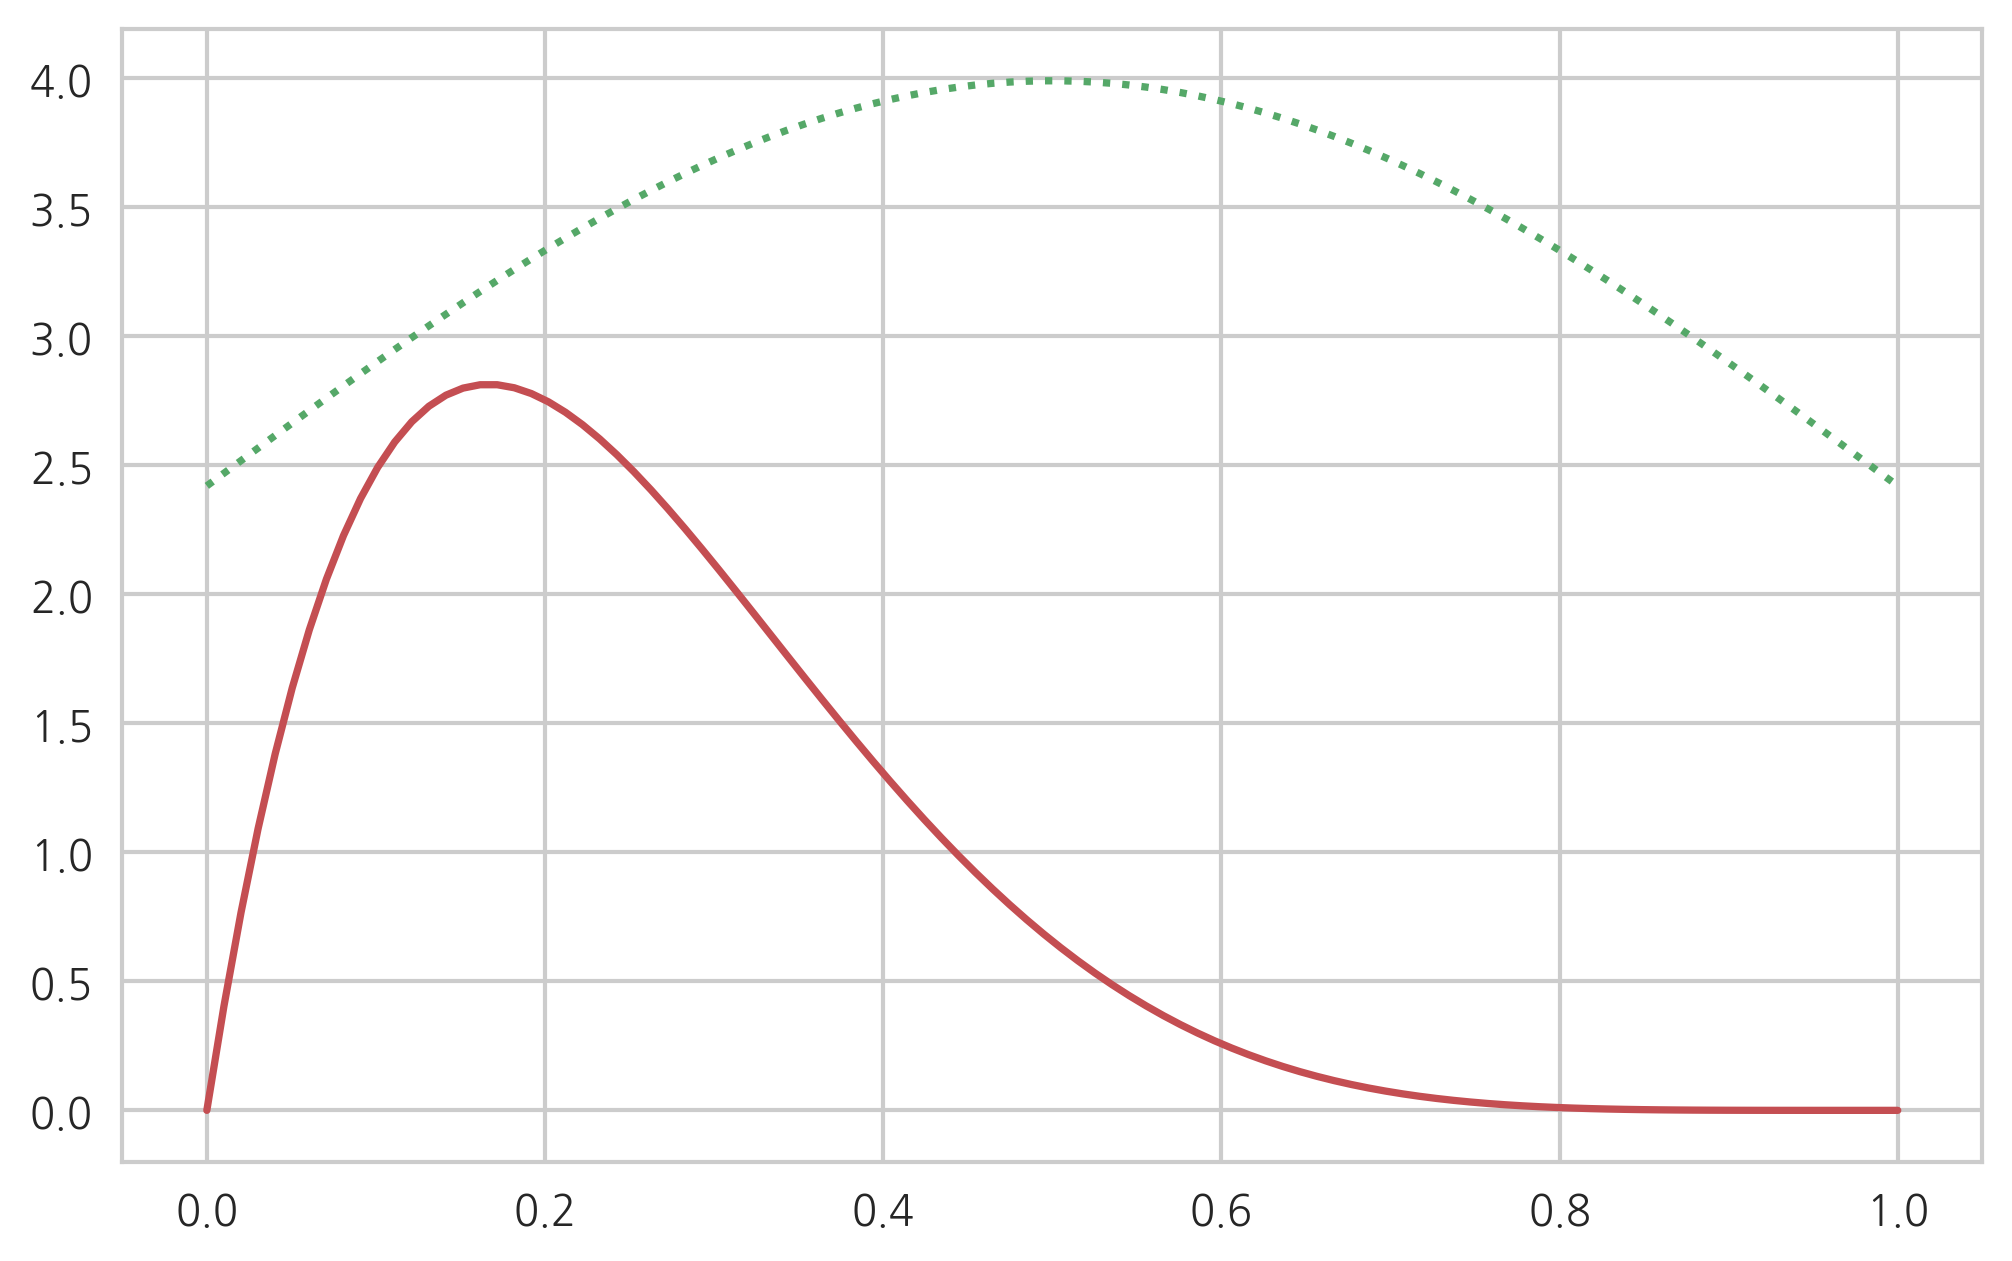

In [2]:
xx = np.linspace(0, 1, 100)
plt.plot(xx, rv_p.pdf(xx), 'r-')
plt.plot(xx, rv_q.pdf(xx) * k, 'g:')
plt.show()

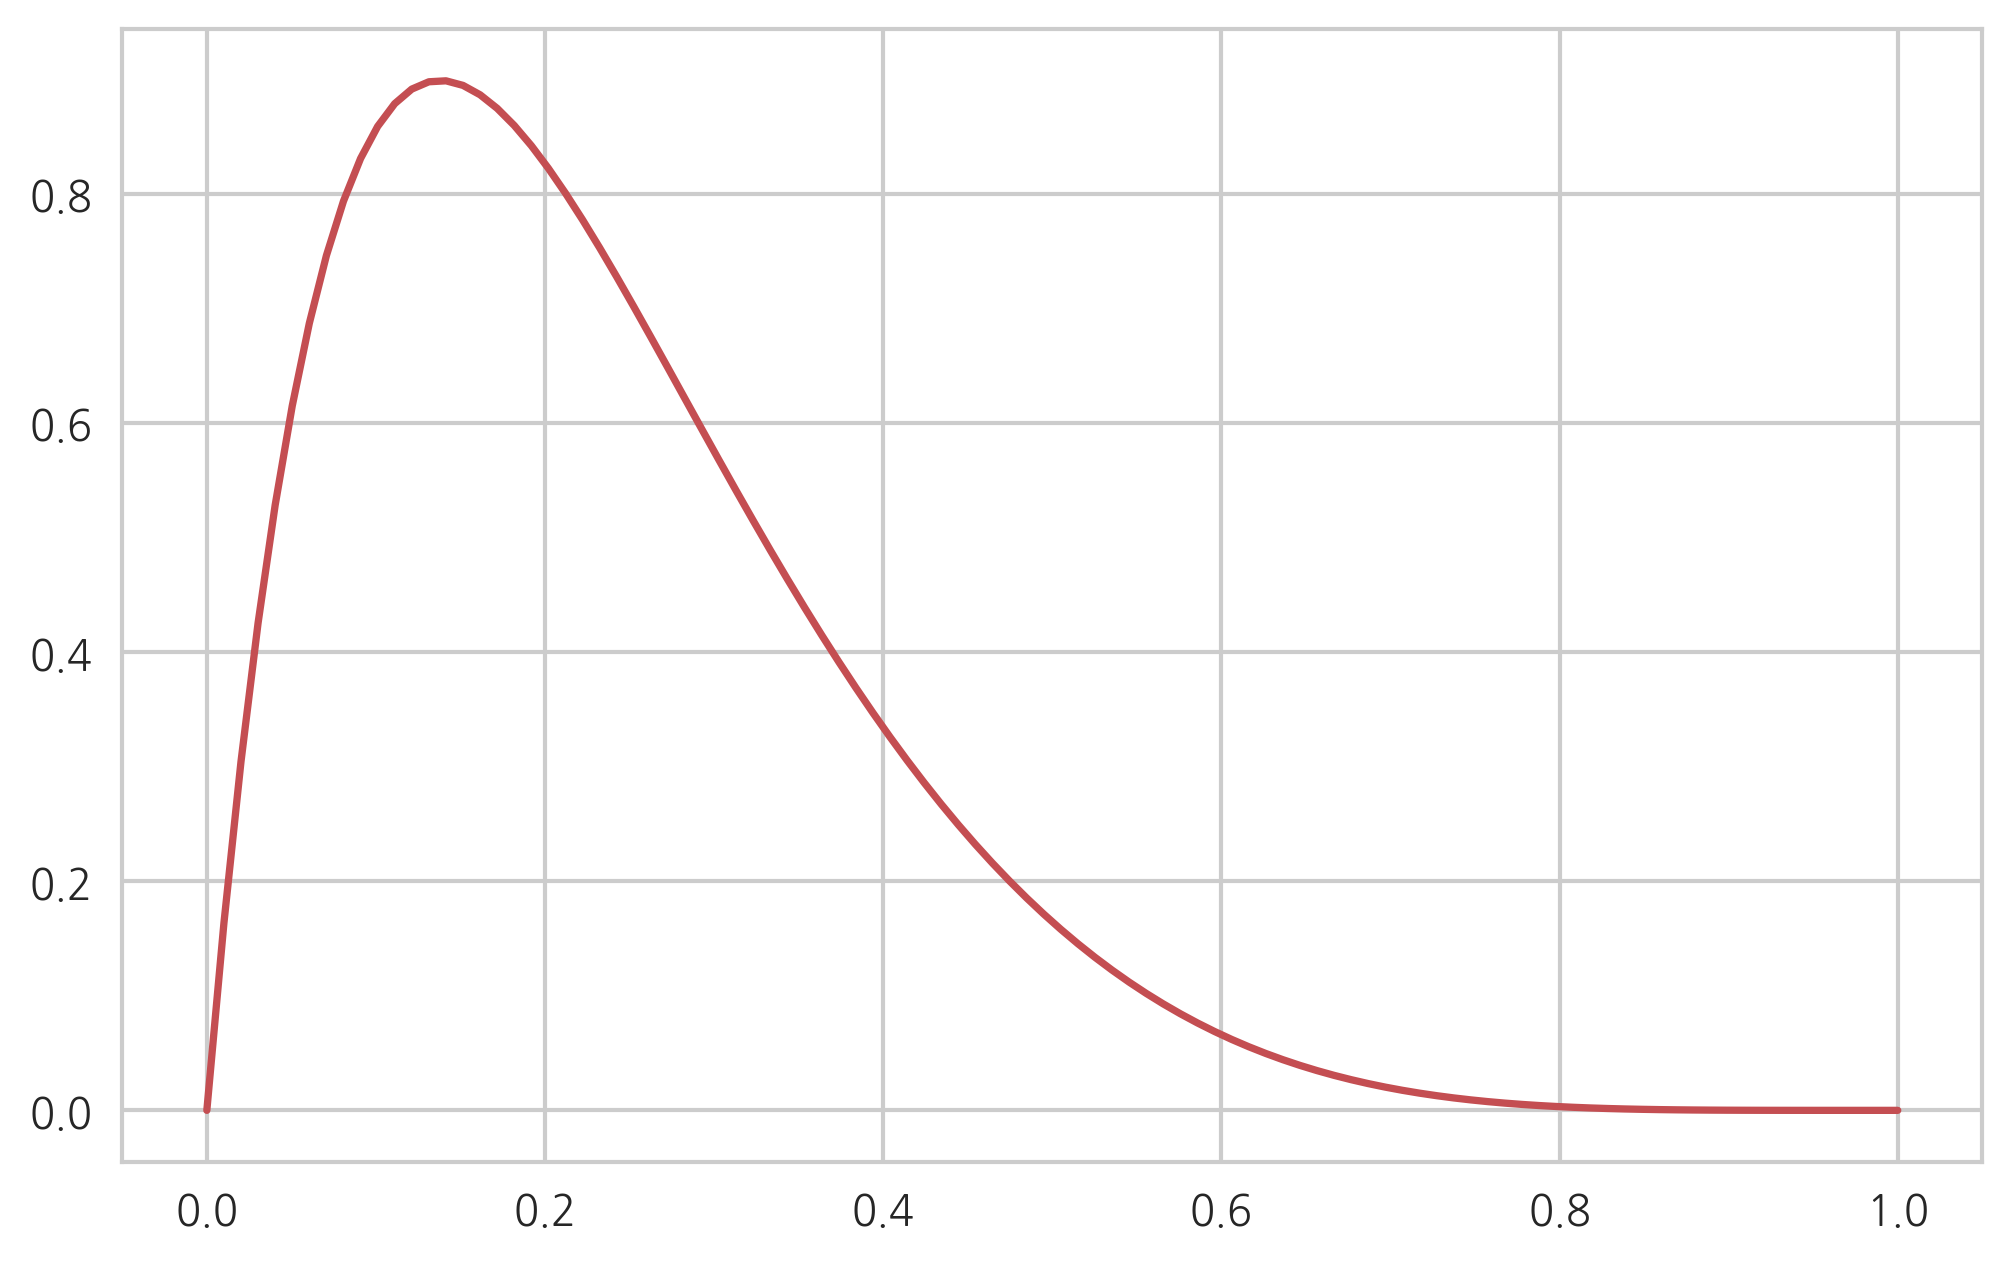

In [3]:
plt.plot(xx, rv_p.pdf(xx) / (rv_q.pdf(xx) * k), 'r-')
plt.show()

In [4]:
np.random.seed(1)
x_q0 = rv_q.rvs(int(1e4))
x_q = x_q0[(x_q0 >= 0) & (x_q0 <= 1)]
crits = rv_p.pdf(x_q) / (rv_q.pdf(x_q) * k)
coins = np.random.rand(len(x_q))
x_p = x_q[coins < crits]

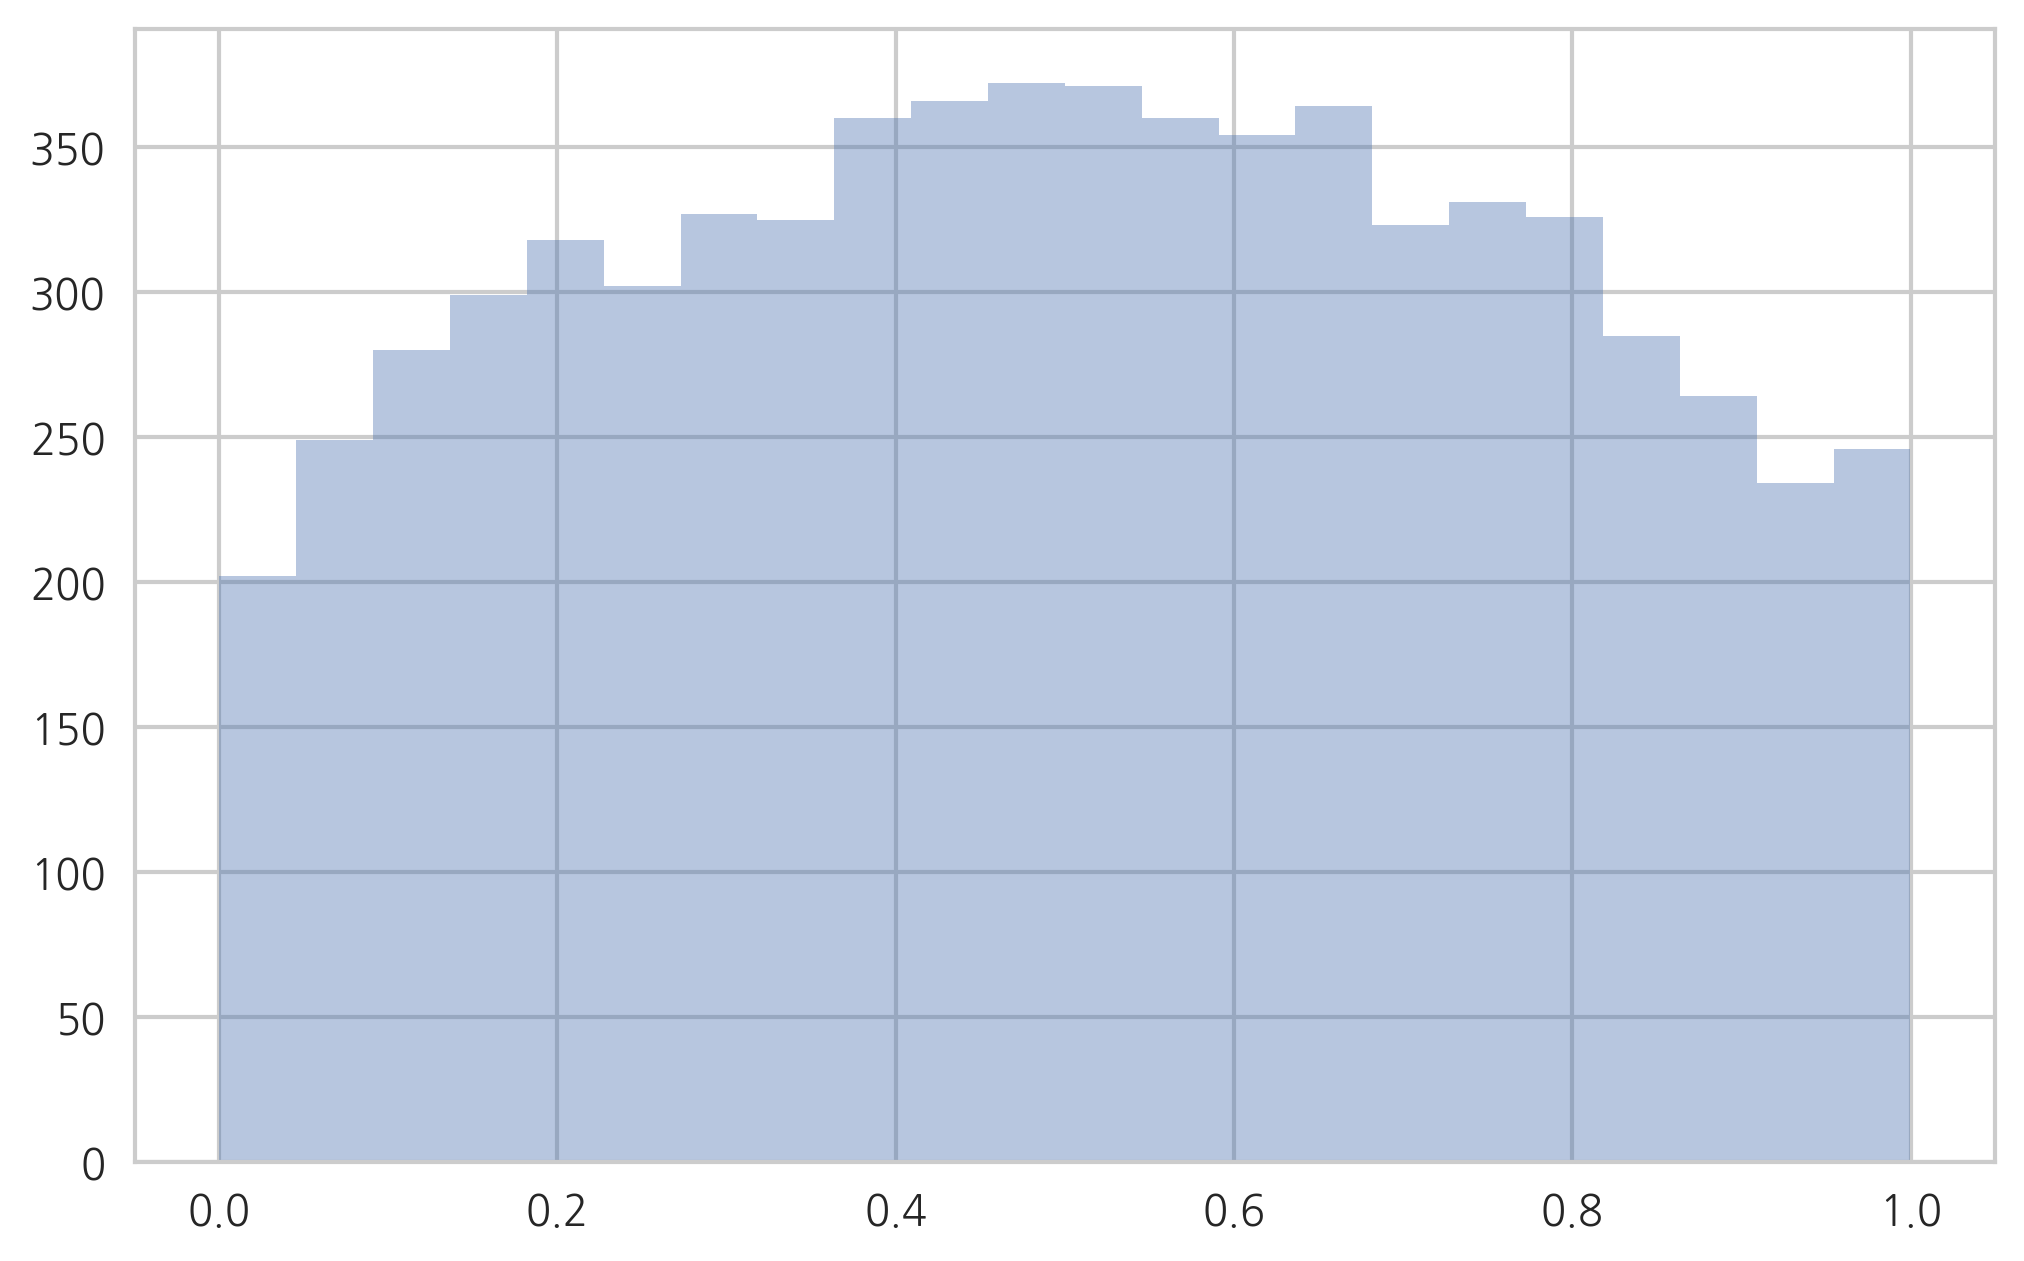

In [5]:
sns.distplot(x_q, kde=False)
plt.show()

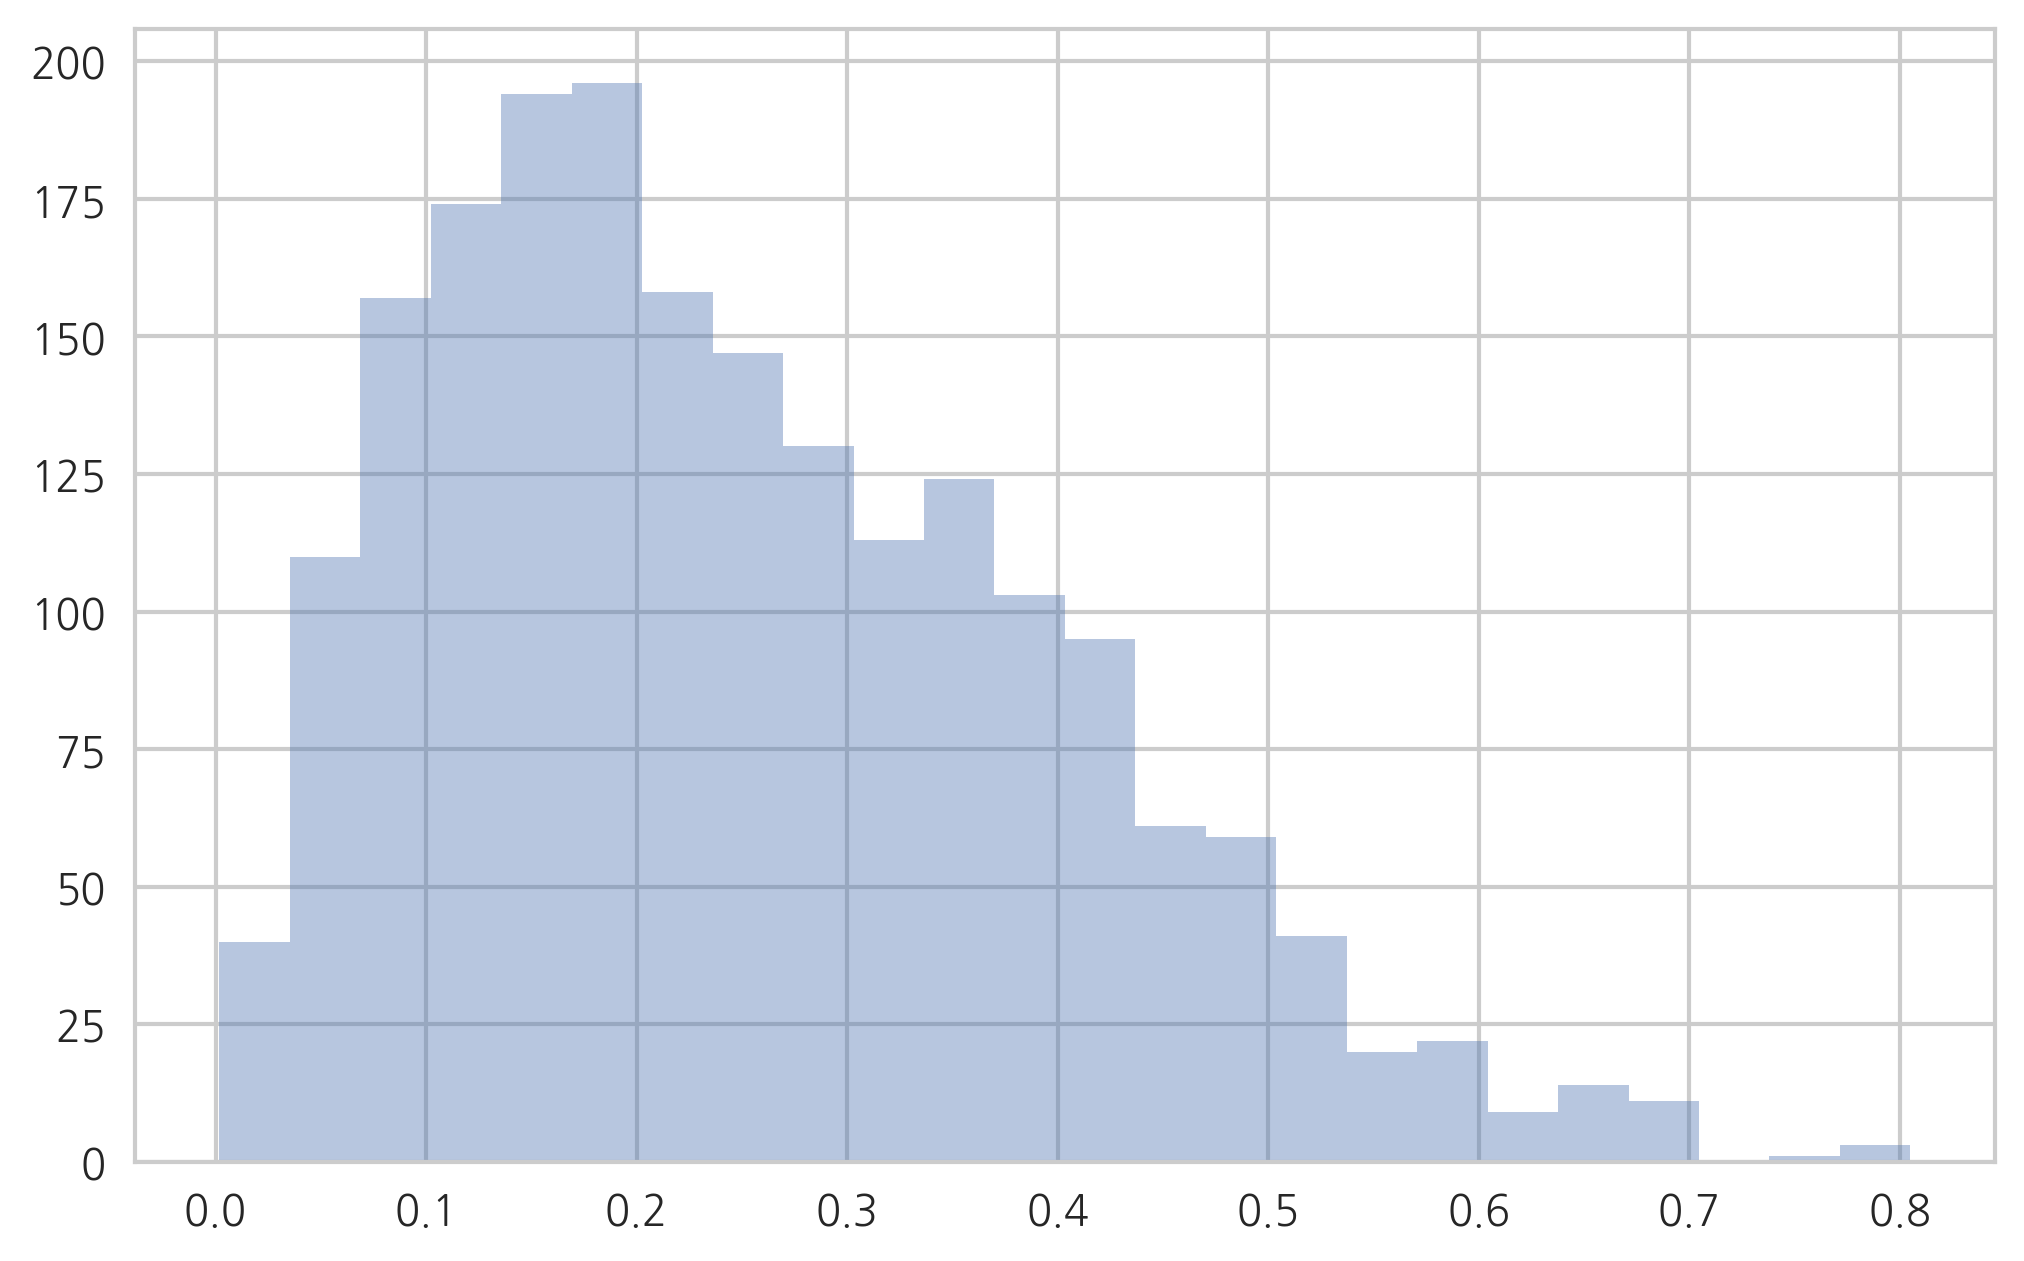

In [6]:
sns.distplot(x_p, kde=False)
plt.show()

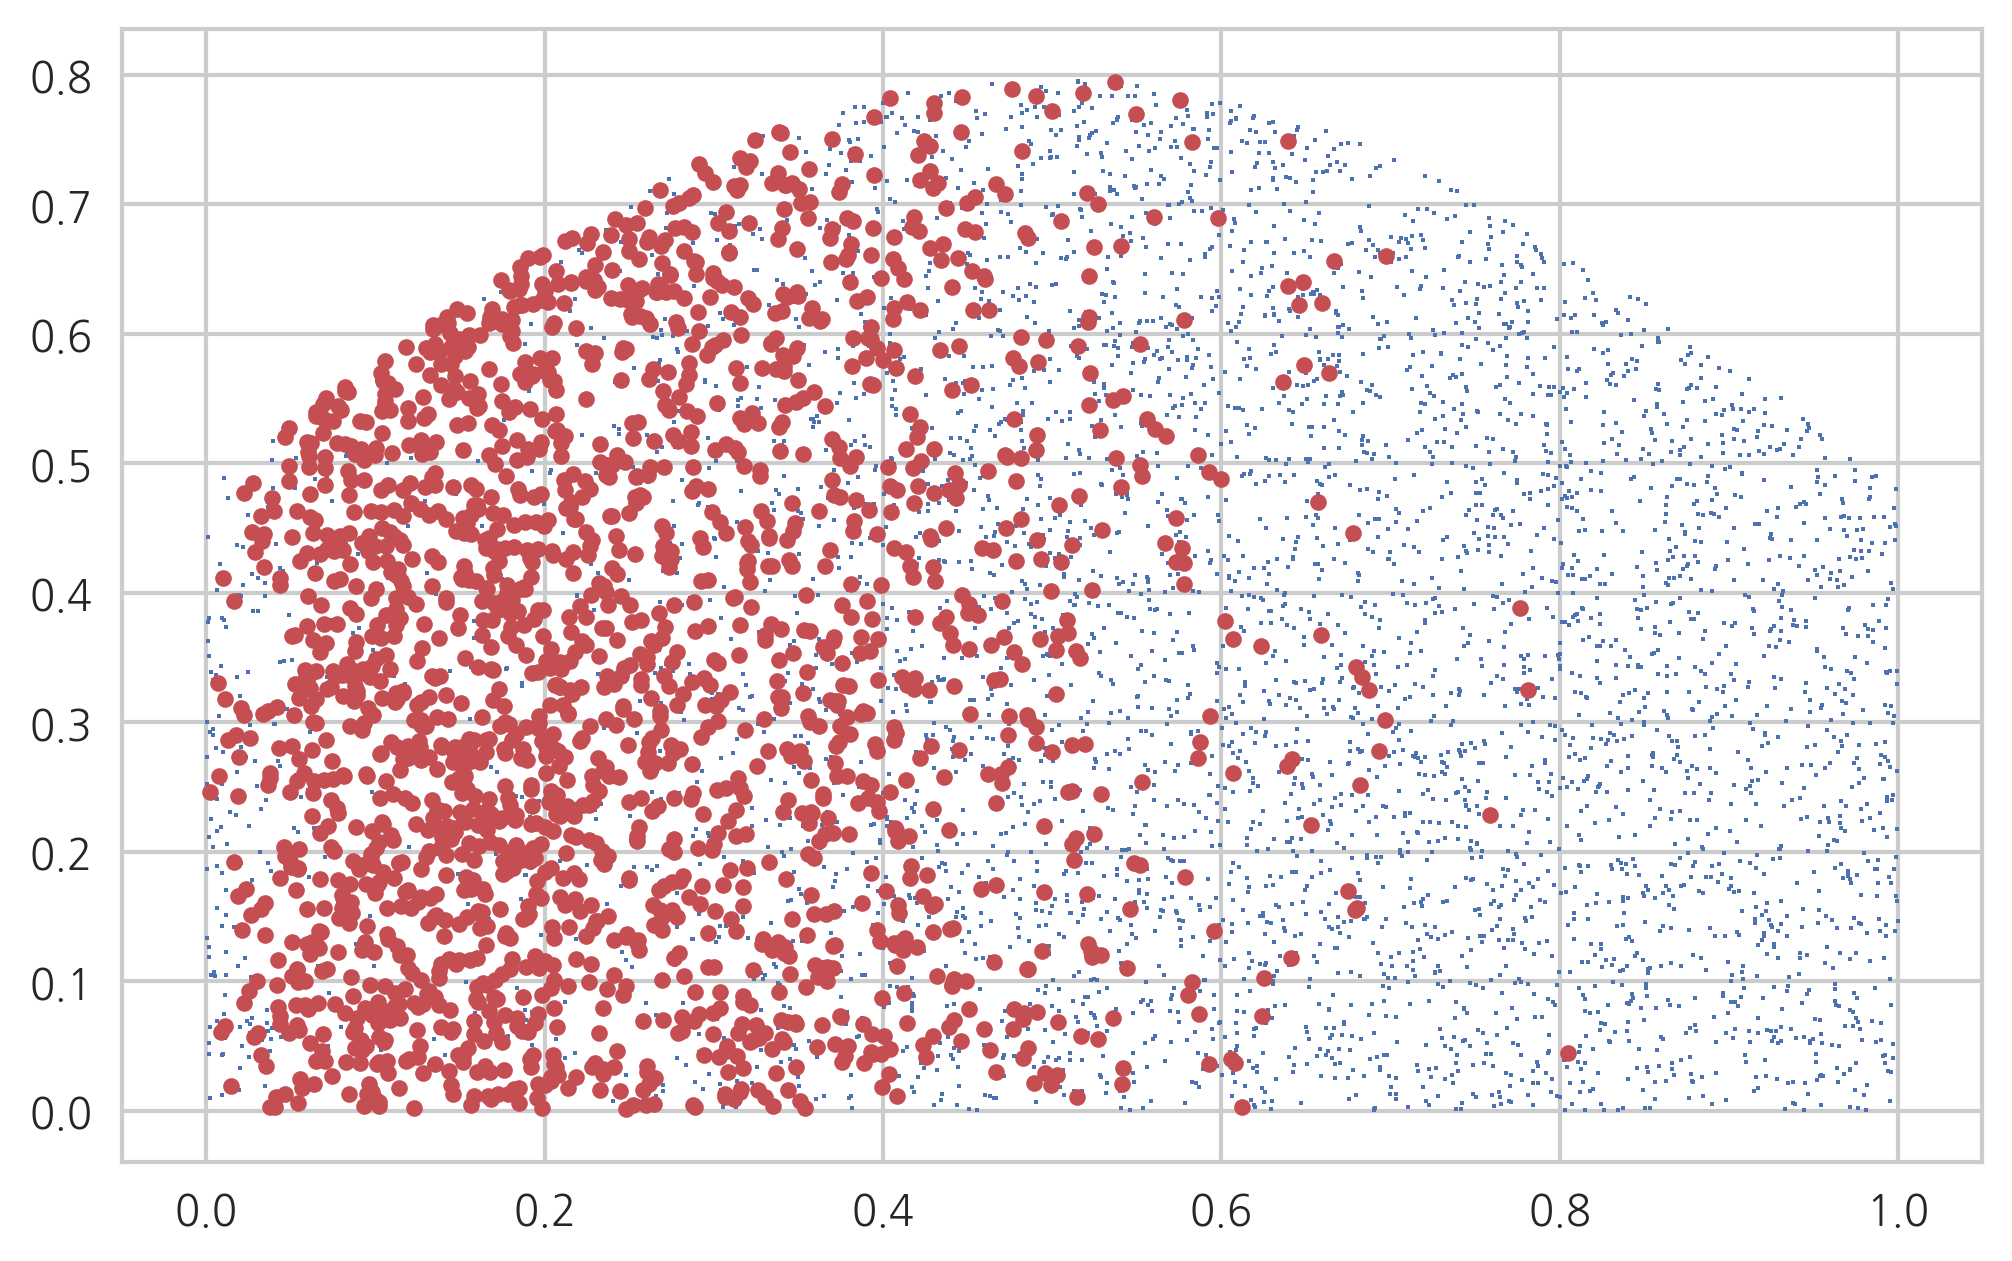

In [7]:
y = np.random.rand(len(x_q)) * rv_q.pdf(x_q)
plt.plot(x_q, y, 'bs', ms=1)
ids = coins < crits
plt.plot(x_q[ids], y[ids], 'ro', ms=4)
plt.show()

## Expectation Approximation Using Sampling

$$ \text{E}[f(X)] = \int f(x)p(x)dx $$

$$ \text{E}[f(X)] \approx \dfrac{1}{N} \sum_{i=1}^N f(x_i) $$

## Importance Sampling

$$
\begin{eqnarray}
\text{E}[f(X)] 
&=& \int f(x)p(x)dx  \\
&=& \int f(x)\dfrac{p(x)}{q(x)} q(x) dx  \\
&\approx & \dfrac{1}{N} \sum_{i=1}^N f(x_i)\dfrac{p(x_i)}{q(x_i)}  \\
\end{eqnarray}
$$

In [8]:
mean = a / (a + b)
mean

0.25

In [9]:
np.mean(x_p)

0.25317146797551493

In [10]:
np.mean(x_q0 * rv_p.pdf(x_q0) / rv_q.pdf(x_q0))

0.25016824587488934

In [12]:
len(x_p), len(x_q0)

(1982, 10000)

## Conditional Probability and Markov Chain

$$ p(x^{(t + 1)}) = \sum_{x^{(t)}} p(x^{(t + 1)} \mid x^{(t)}) p(x^{(t)}) $$

* detailed balance 조건을 만족하면 특정한 분포로 수렴

## MCMC(Markov Chain Monte Carlo)

* Markov Chain의 최종 수렴 분포가 원하는 분포 $p(x)$가 되도록 하는  Markov Chain을 만든다.

## Metropolis-Hastings Sampling

1. (step 0) $x^{(0)}$ 생성
1. (step 1) 샘플링 가능한 $q(x^{\ast} \mid x^{(t)})$ 분포로 $x^{\ast}$ 생성
1. (step 2) 다음 확률로 $x^{(t+1)} = x^{\ast}$ 선택, 선택되지 않으면 $x^{(t+1)} = x^{(t)}$
$$ \min \left( 1, \dfrac{p(x^{\ast}) q(x^{(t)} \mid x^{\ast})}{p(x^{(t)}) q(x^{\ast} \mid x^{(t)})} \right)$$
1. 충분한 수의 샘플이 모일때까지 (step 1) ~ (step 2) 반복

<img src="https://datascienceschool.net/upfiles/02bc071a711d429c94582e30b5d2597f.png">

## Hamiltonian Monte Carlo

* gradient 정보를 사용하여 리젝트 확률 감소

## PyMC3

* MCMC Bayesian in Python
* Theano backend

In [13]:
import pymc3 as pm

In [14]:
cov = np.array([[1., 1.5], [1.5, 4]])
mu = np.array([1, -1])

In [15]:
with pm.Model() as model:
    x = pm.MvNormal('x', mu=mu, cov=cov, shape=(1, 2))
    step = pm.Metropolis()
    trace = pm.sample(5000, step)

100%|██████████| 5500/5500 [00:02<00:00, 2663.97it/s]


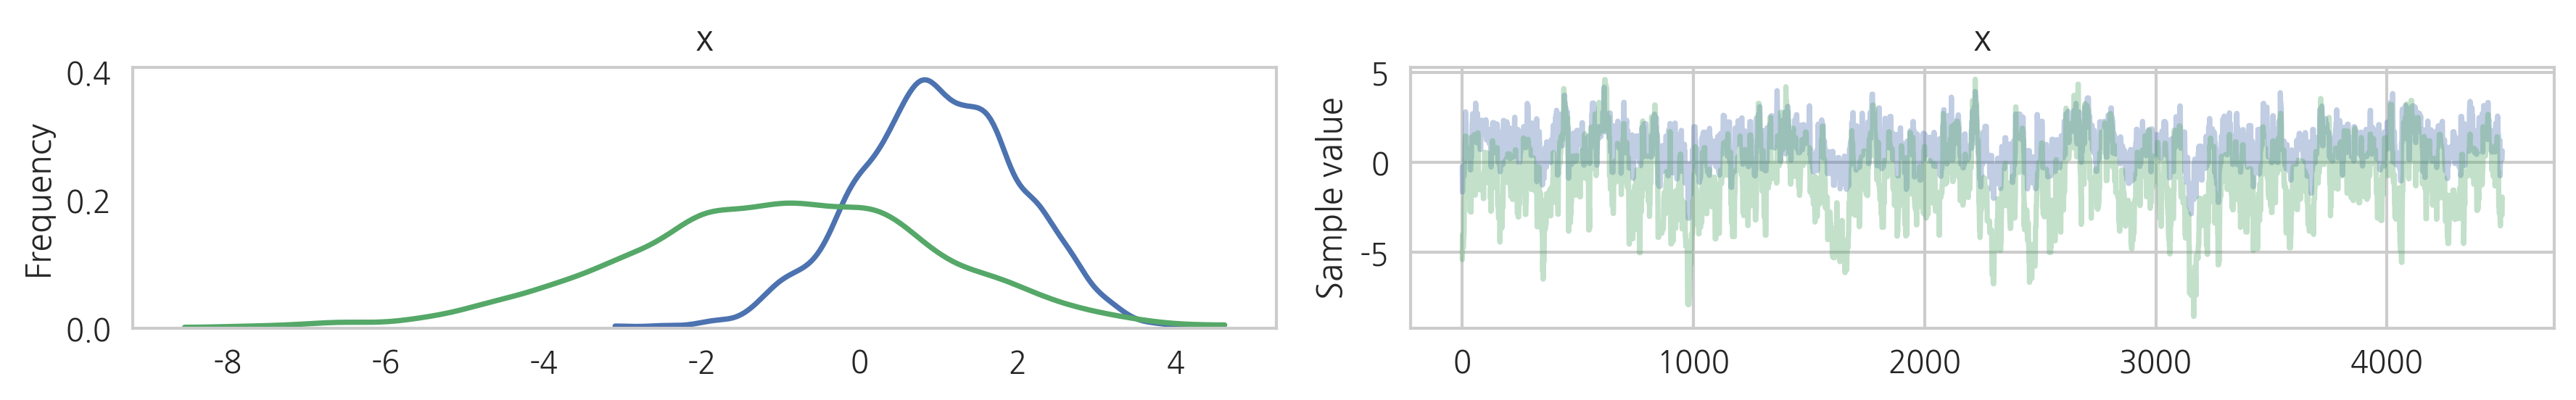

In [16]:
pm.traceplot(trace, skip_first=500)
plt.show()

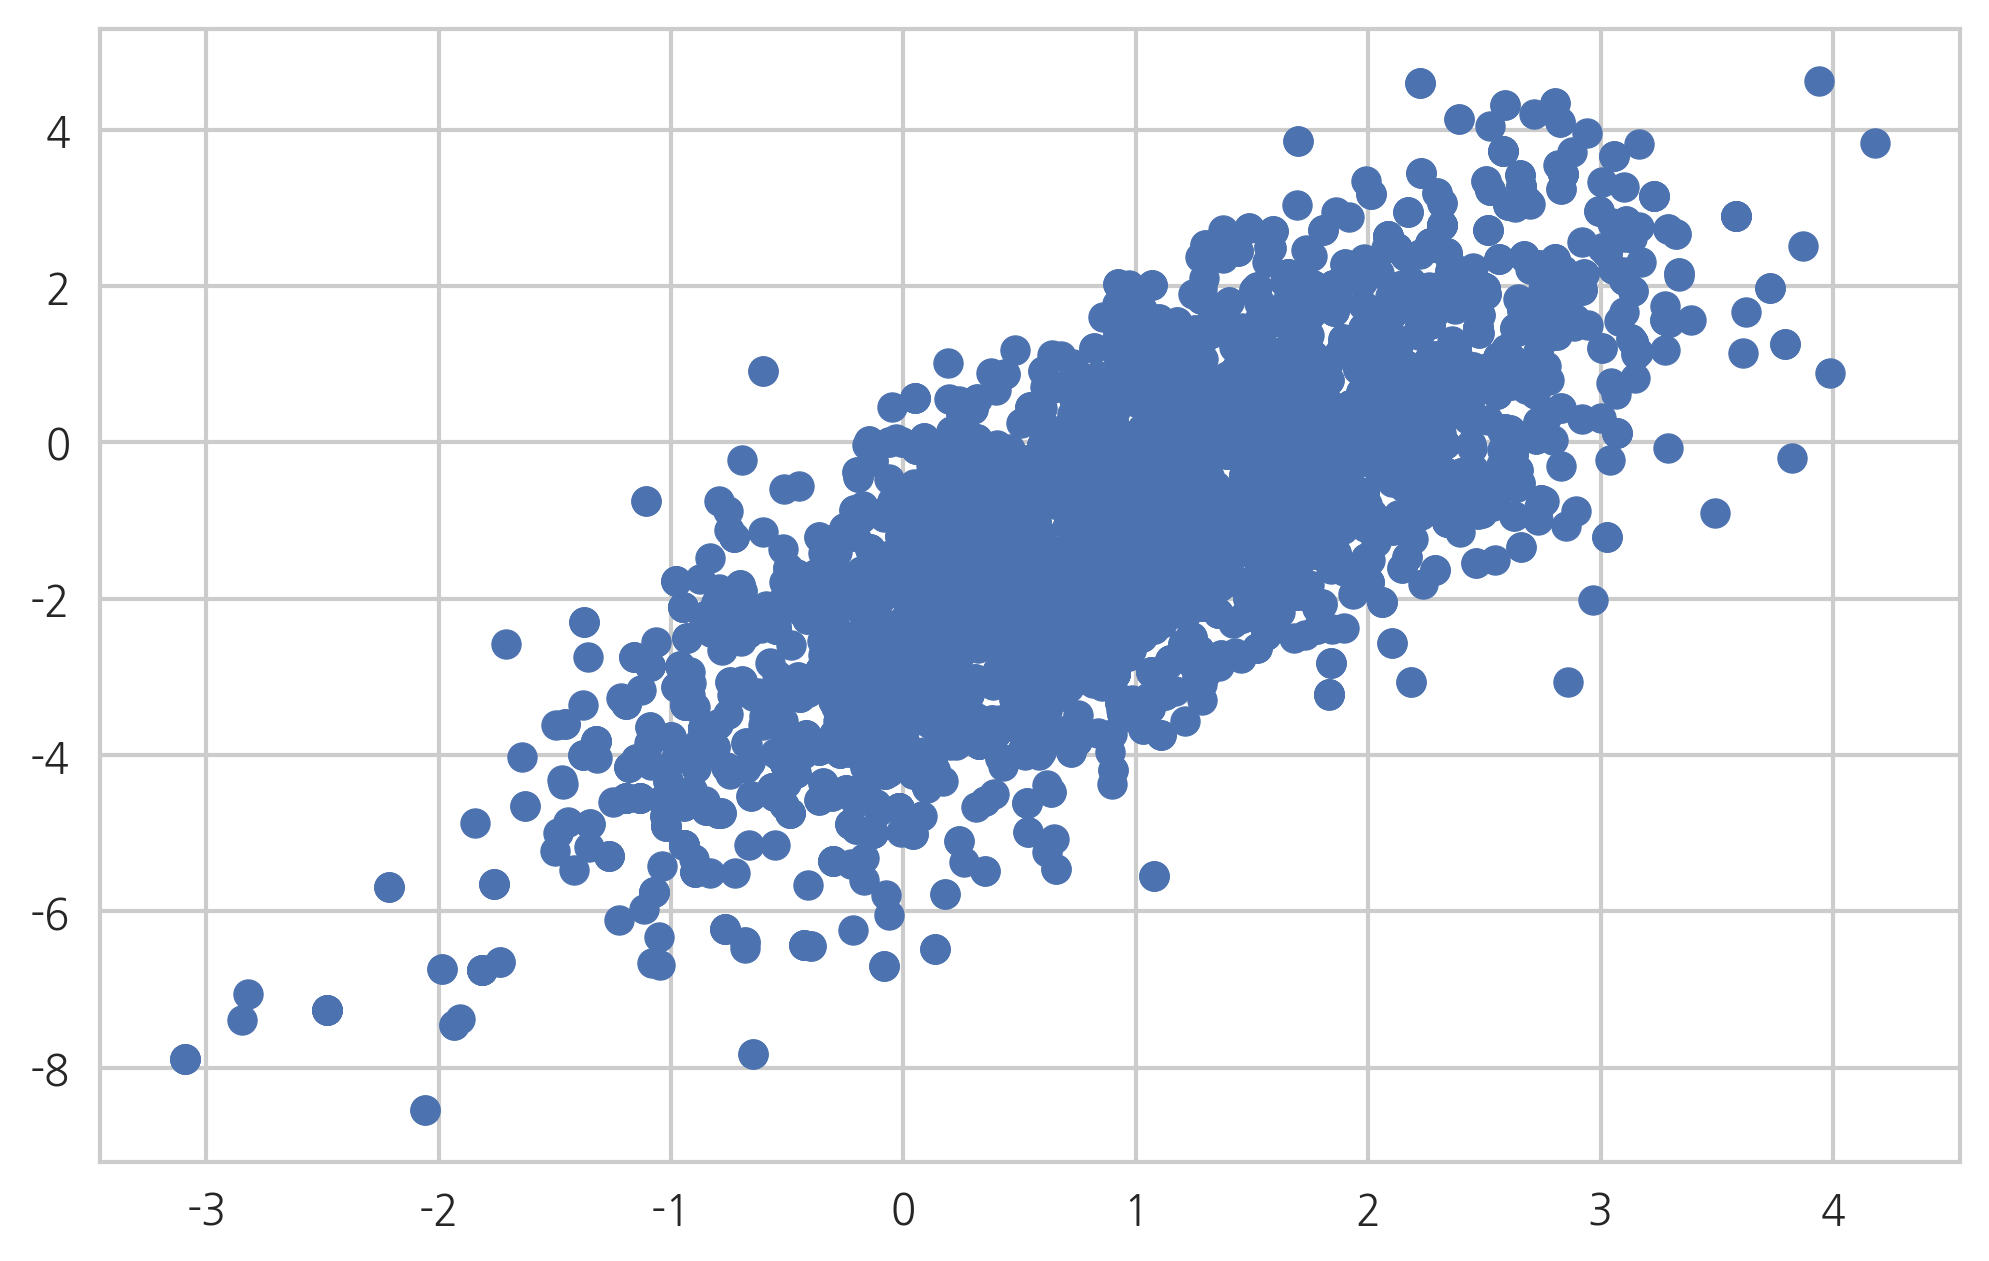

In [17]:
plt.scatter(trace['x'][500:, 0, 0], trace['x'][500:, 0, 1])
plt.show()

## Bayesian Estimation using MCMC

$$ P(\theta \mid x_{1},\ldots,x_{N}) \propto P(x_{1},\ldots,x_{N} \mid \theta)  P(\theta) $$


* $ P(\theta) $: Beta
* $ P(x_{1},\ldots,x_{N} \mid \theta) $: Binomial

In [18]:
theta0 = 0.7
np.random.seed(0)
x_data1 = sp.stats.bernoulli(theta0).rvs(10)
x_data1

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [19]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Bernoulli('x', p=theta, observed=x_data1)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace1 = pm.sample(1000, step=step, start=start)

logp = -6.9315, ||grad|| = 2: 100%|██████████| 6/6 [00:00<00:00, 1183.33it/s]
100%|██████████| 1500/1500 [00:01<00:00, 1499.19it/s]


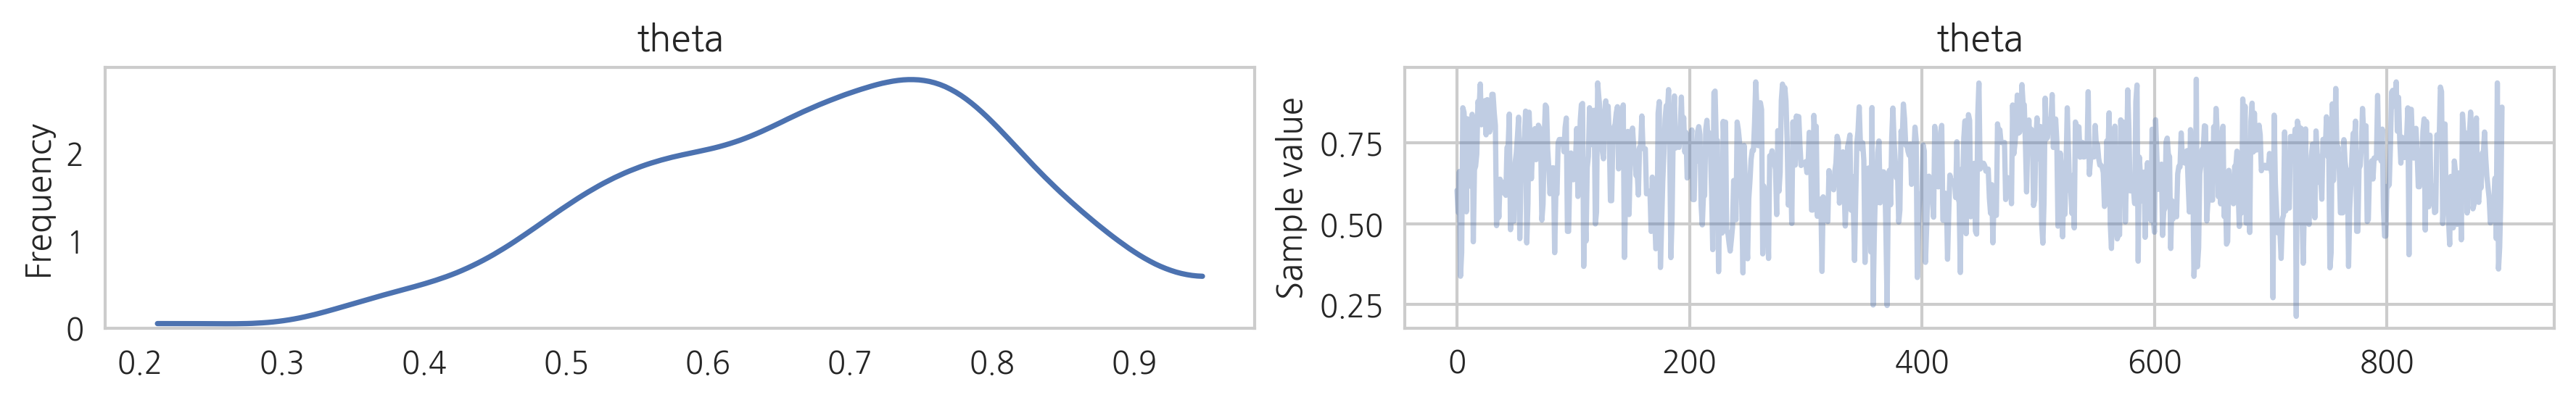

In [20]:
pm.traceplot(trace1, skip_first=100);

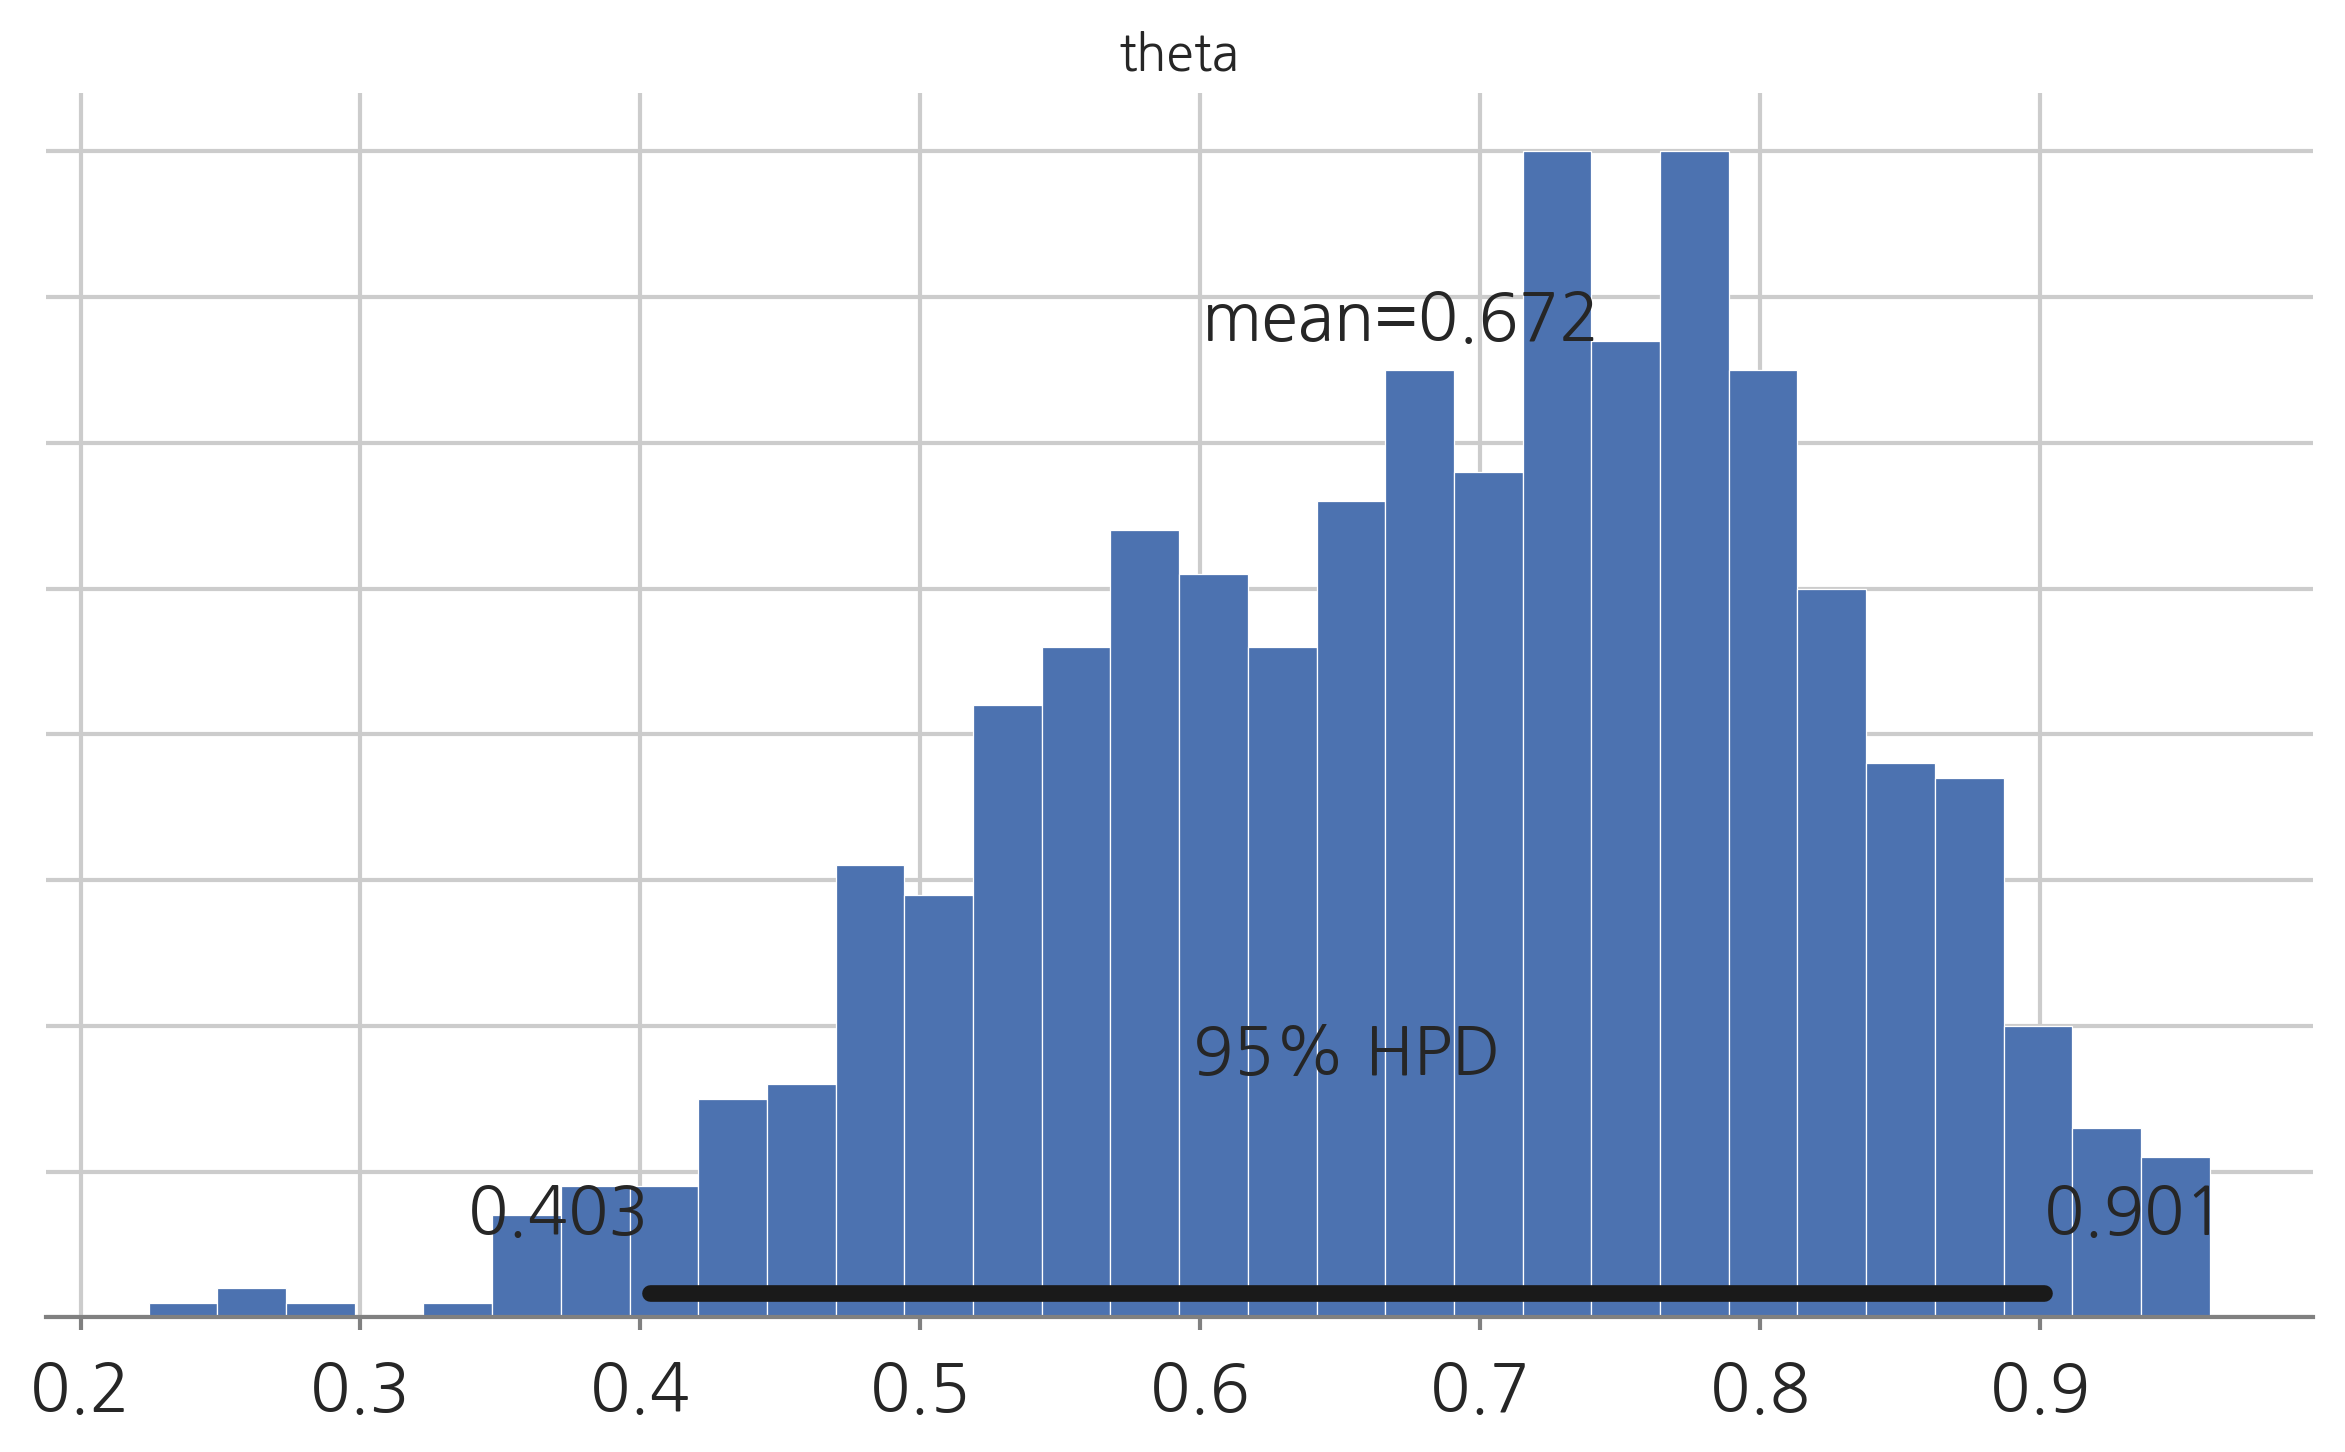

In [21]:
pm.plot_posterior(trace1)
plt.show()

In [22]:
pm.summary(trace1)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.672            0.133            0.006            [0.403, 0.901]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.392          0.575          0.684          0.771          0.899



In [23]:
print(pm.df_summary(trace1))

          mean        sd  mc_error   hpd_2.5  hpd_97.5
theta  0.67156  0.133365  0.006041  0.403376  0.901421


In [24]:
np.random.seed(0)
x_data2 = sp.stats.bernoulli(theta0).rvs(300)

In [25]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Bernoulli('x', p=theta, observed=x_data2)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace2 = pm.sample(1000, step=step, start=start)

logp = -207.94, ||grad|| = 65: 100%|██████████| 7/7 [00:00<00:00, 622.41it/s]
100%|██████████| 1500/1500 [00:01<00:00, 1441.40it/s]


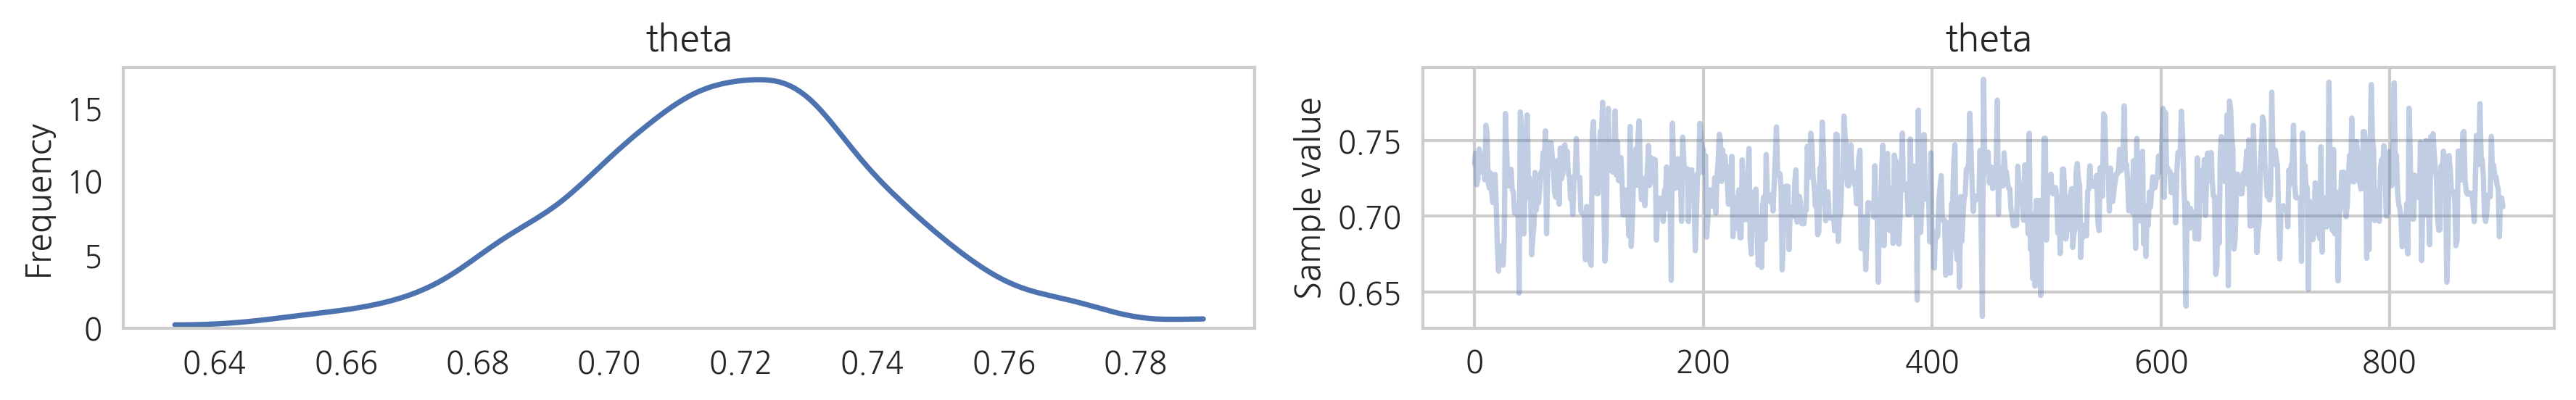

In [26]:
pm.traceplot(trace2, skip_first=100);

In [27]:
print(pm.df_summary(trace2))

          mean        sd  mc_error   hpd_2.5  hpd_97.5
theta  0.71749  0.024576  0.001233  0.673357  0.771205


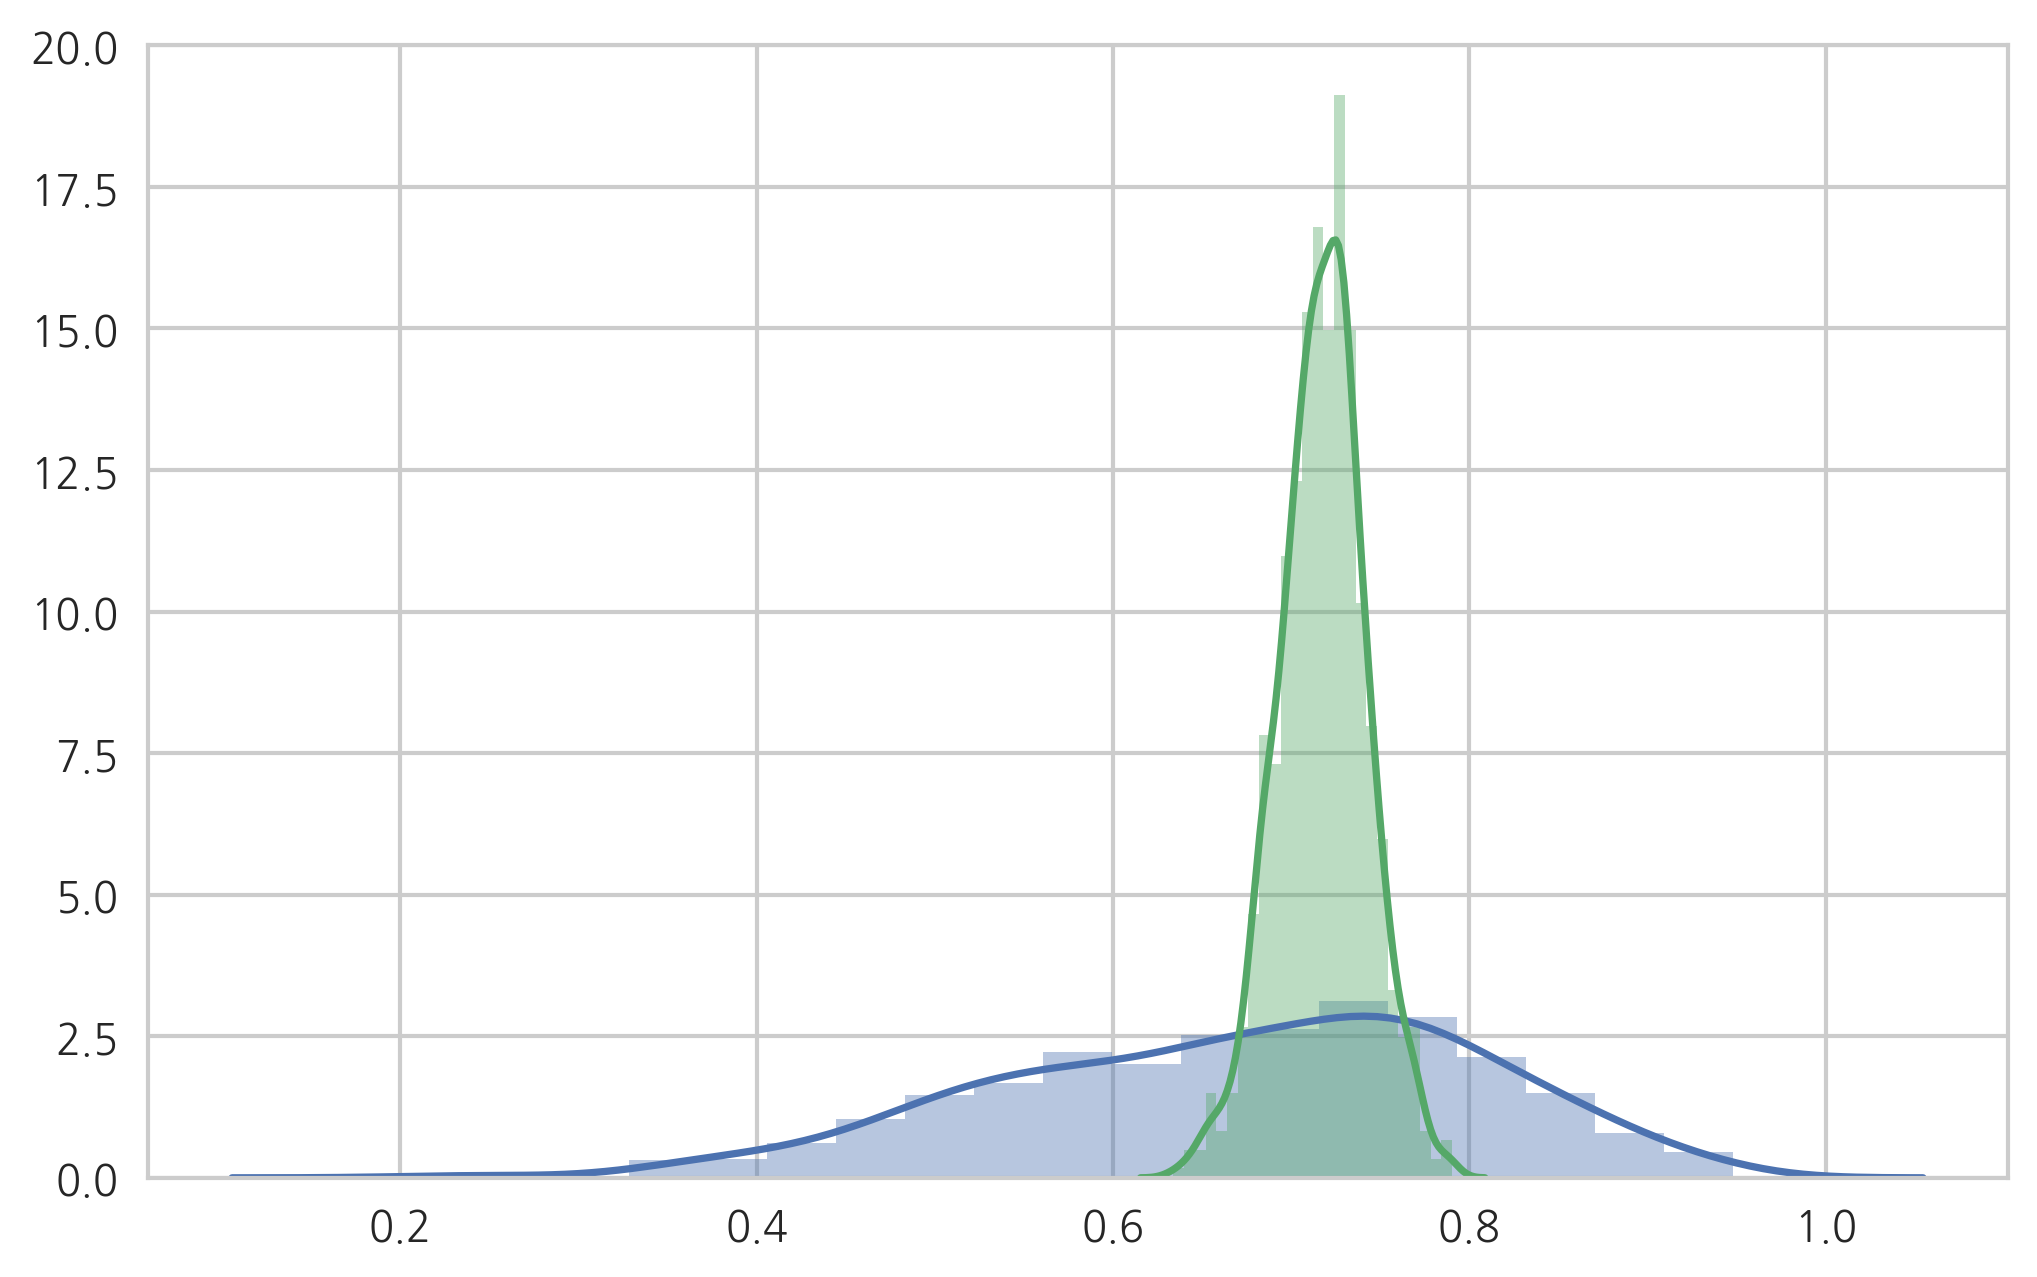

In [28]:
sns.distplot(trace1['theta'])
sns.distplot(trace2['theta'])
plt.ylim(0, 20)
plt.show()

## Bayesian Linear Regression using MCMC

In [29]:
from sklearn.datasets import make_regression

x, y_data, coef = make_regression(n_samples=100, n_features=1, bias=0, noise=20, coef=True, random_state=1)
x = x.flatten()
coef

array(80.71051956187792)

In [30]:
# 레버리지가 높은 가상의 데이터를 추가
data_100 = (4, 300)
data_101 = (3, -100)
x = np.hstack([x, [data_100[0], data_101[0]]])
y_data = np.hstack([y_data, [data_100[1], data_101[1]]])

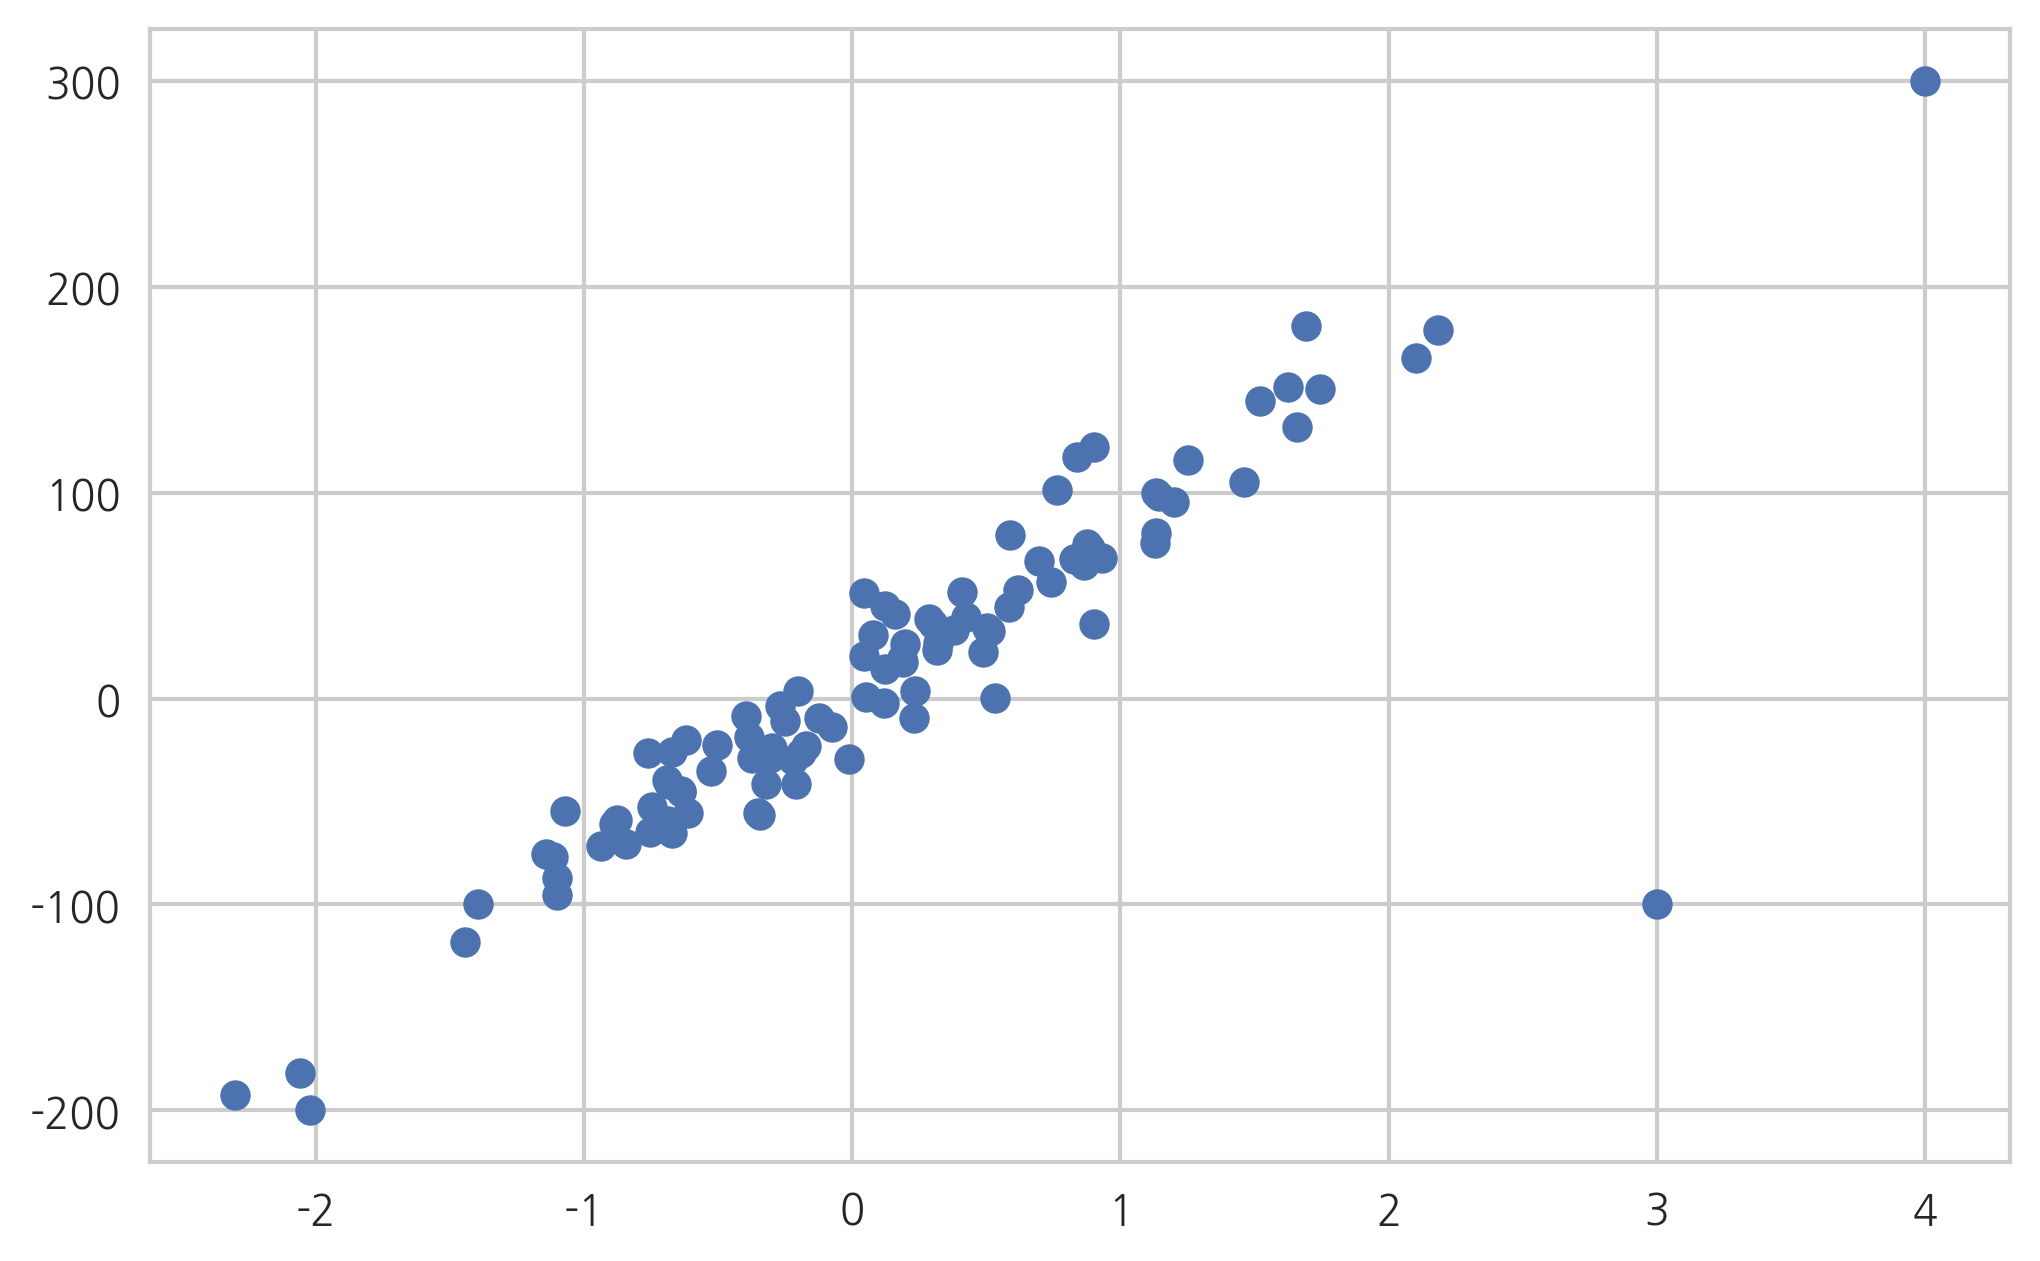

In [31]:
plt.scatter(x, y_data)
plt.show()

In [32]:
with pm.Model() as m:
    w = pm.Normal('w', mu=0, sd=50)
    b = pm.Normal('b', mu=0, sd=50)
    mu = pm.Deterministic('mu', w * x + b)
    esd = pm.HalfCauchy('esd', 5)
    y = pm.Normal('y', mu=mu, sd=esd, observed=y_data)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace1 = pm.sample(10000, step=step, start=start)

logp = -531.74, ||grad|| = 11.351: 100%|██████████| 37/37 [00:00<00:00, 952.01it/s]  
100%|██████████| 10500/10500 [00:10<00:00, 989.66it/s]


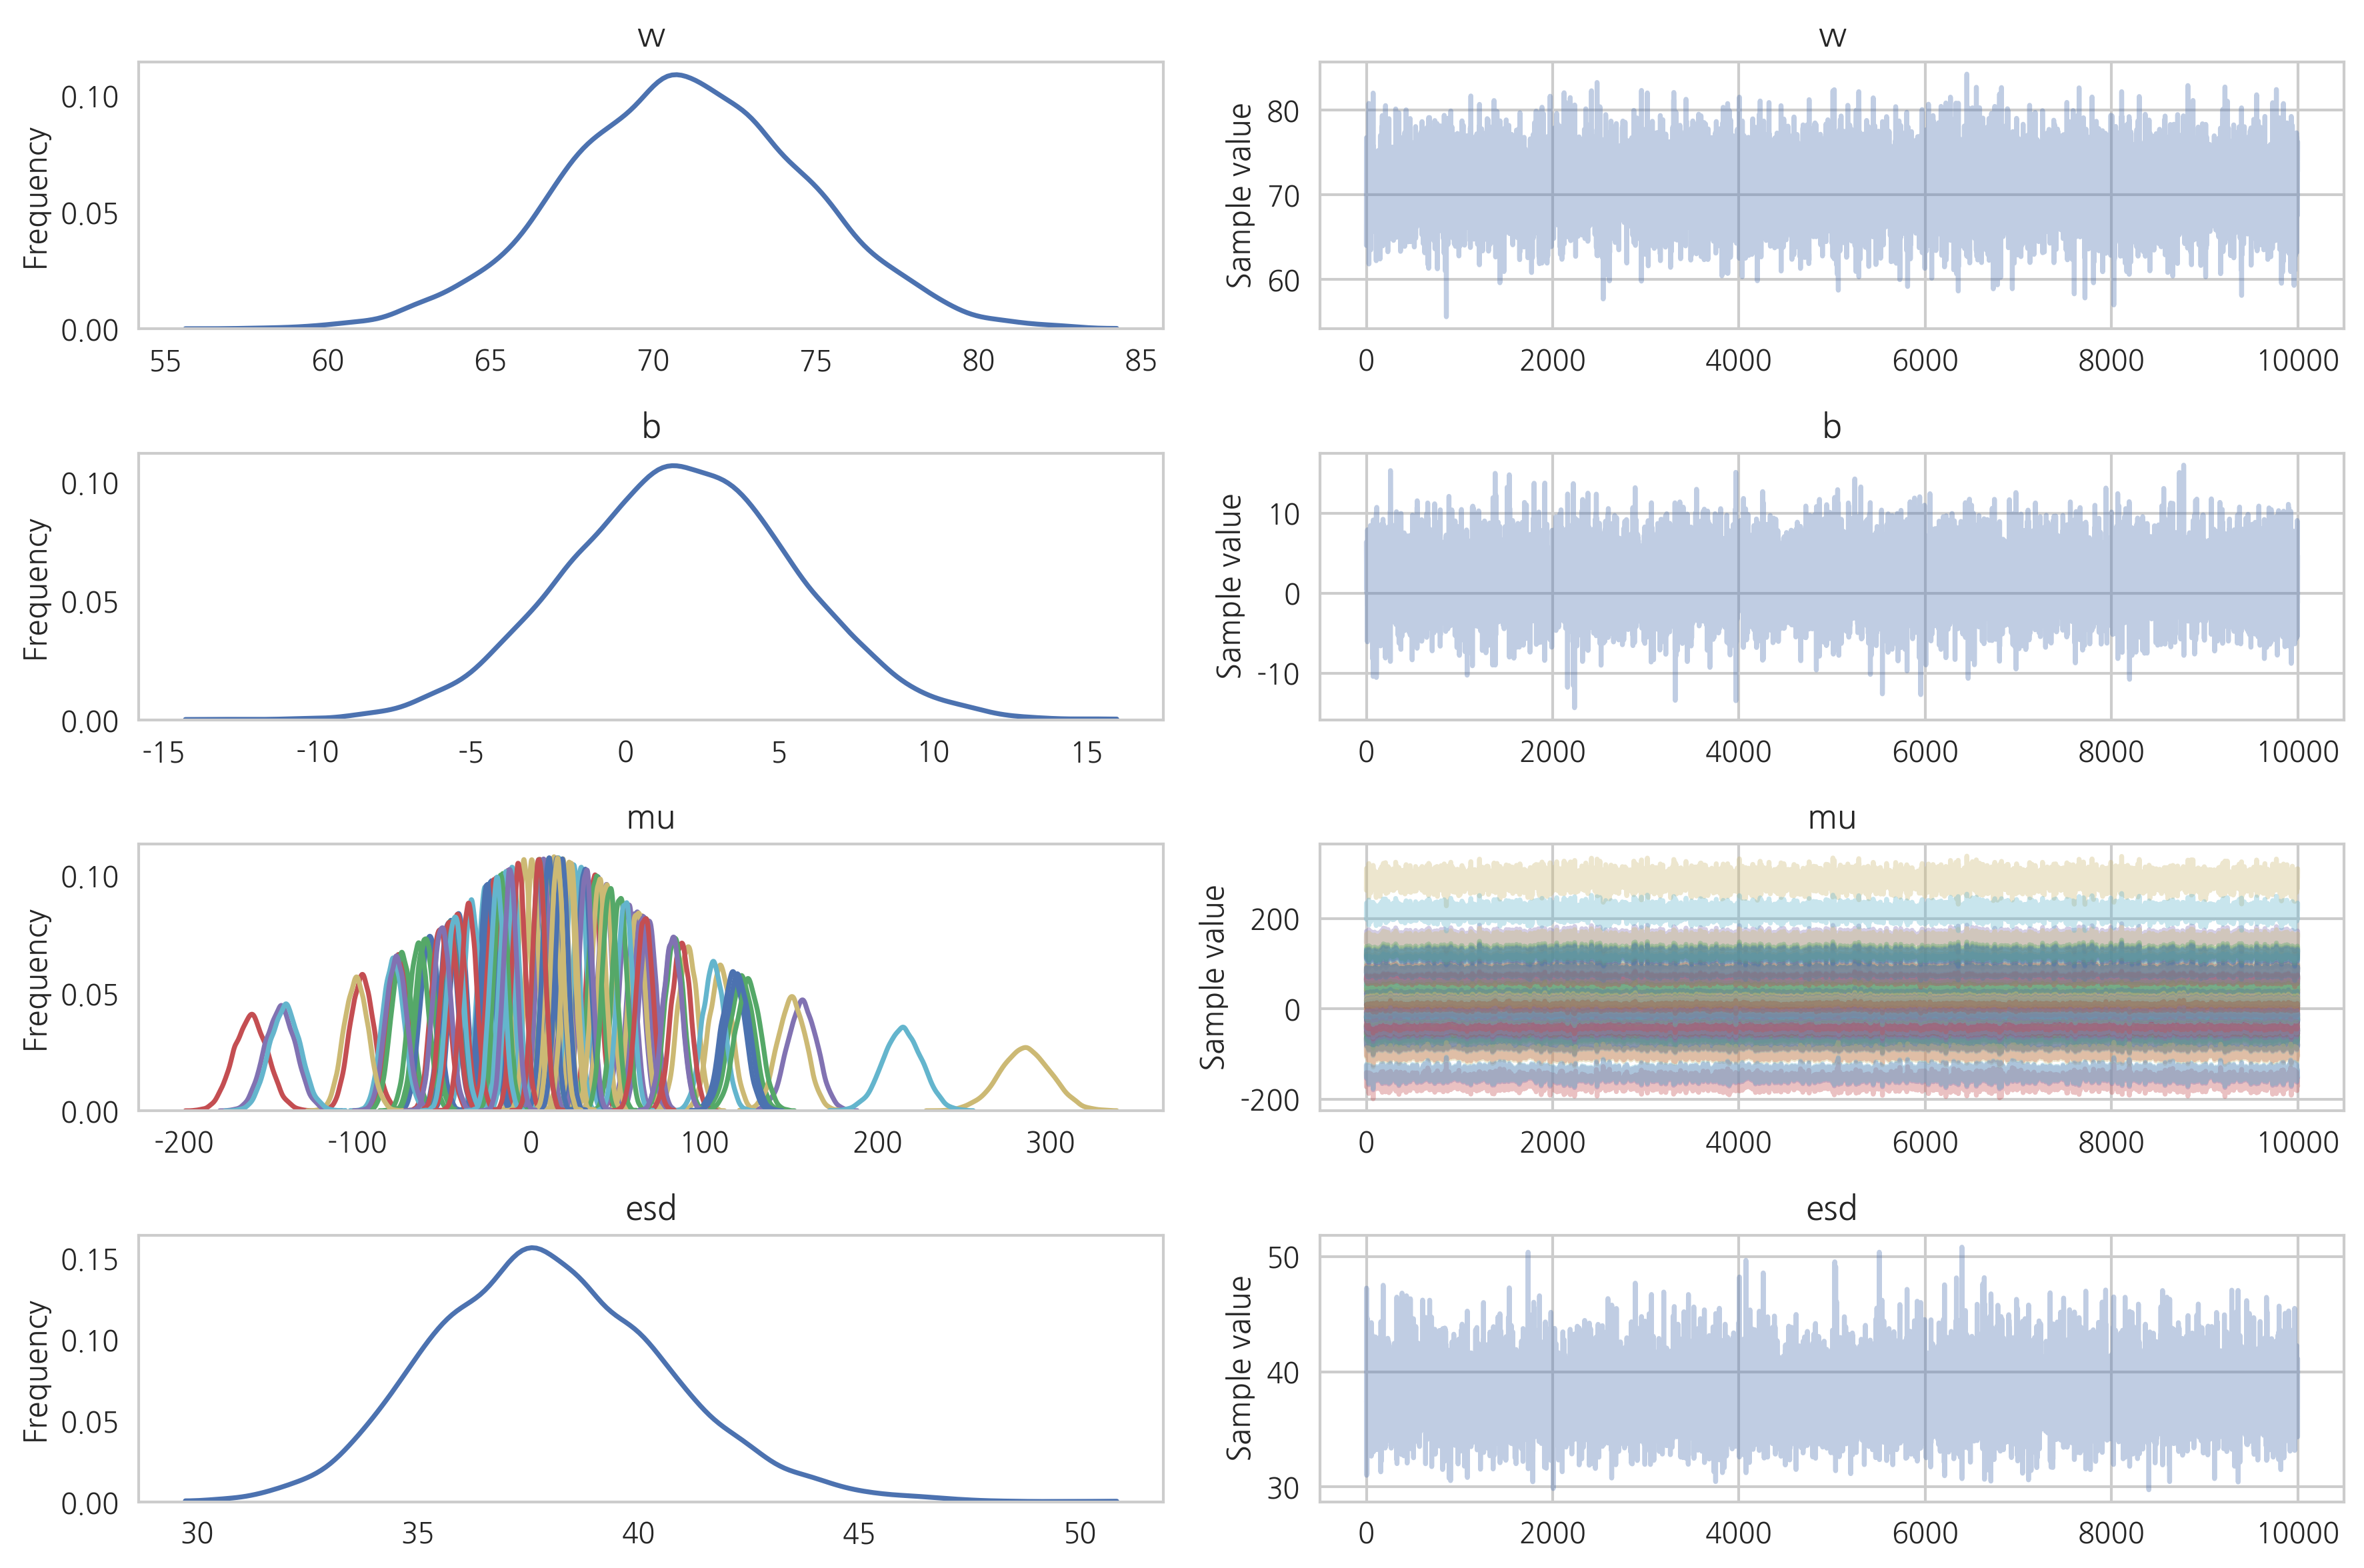

In [33]:
pm.traceplot(trace1)
plt.show()

In [35]:
print(pm.df_summary(trace1))

               mean         sd  mc_error     hpd_2.5    hpd_97.5
w         70.911706   3.723455  0.030742   63.775767   78.386586
b          1.742626   3.725457  0.031392   -5.275692    9.255947
mu__0    -41.638065   4.615524  0.039680  -50.884009  -32.894370
mu__1    -15.940653   3.956313  0.033766  -23.455373   -8.122491
mu__2     36.384281   3.924614  0.031986   28.673995   44.052153
mu__3     55.778139   4.375488  0.035229   46.957962   64.070275
mu__4    109.515429   6.352114  0.050831   96.988170  121.849742
mu__5     28.516318   3.804702  0.031224   21.155412   36.014314
mu__6     38.115355   3.956302  0.032199   30.191993   45.680459
mu__7    -45.856582   4.751698  0.040860  -55.323013  -36.783472
mu__8    -97.285311   6.783794  0.058015 -110.612484  -84.200398
mu__9     24.124839   3.755912  0.030955   17.025327   31.729378
mu__10   -43.427822   4.672500  0.040175  -52.642635  -34.402134
mu__11   -26.391843   4.184641  0.035873  -34.580223  -18.308411
mu__12   -76.304157   5.8

In [36]:
model = sm.OLS.from_formula('y ~ x', data=pd.DataFrame({'x': x, 'y': y_data}))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     360.9
Date:                Sat, 25 Nov 2017   Prob (F-statistic):           5.92e-35
Time:                        16:38:22   Log-Likelihood:                -514.53
No. Observations:                 102   AIC:                             1033.
Df Residuals:                     100   BIC:                             1038.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7063      3.785      0.451      0.6

## Robust Bayesian Regression

In [43]:
with pm.Model() as m:
    w = pm.Normal('w', mu=0, sd=50)
    b = pm.Normal('b', mu=0, sd=50)
    mu = pm.Deterministic('mu', w * x + b)
    esd = pm.HalfCauchy('esd', 5)
    y = pm.StudentT('y', mu=mu, sd=esd, nu=3, observed=y_data)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace2 = pm.sample(10000, step=step, start=start)

logp = -468, ||grad|| = 1.0431: 100%|██████████| 40/40 [00:00<00:00, 1236.46it/s]    
100%|██████████| 10500/10500 [00:10<00:00, 1025.48it/s]


In [44]:
print(pm.df_summary(trace2))

               mean        sd  mc_error     hpd_2.5    hpd_97.5
w         79.673300  1.896429  0.016404   76.085050   83.501882
b          3.304750  1.699851  0.014548    0.065747    6.668055
mu__0    -45.435903  2.143420  0.018511  -49.739720  -41.365518
mu__1    -16.563411  1.805381  0.015516  -20.067258  -13.113550
mu__2     42.226602  1.860448  0.015863   38.566816   45.818200
mu__3     64.016695  2.128587  0.018169   59.898804   68.261126
mu__4    124.393571  3.210192  0.027529  118.057895  130.664867
mu__5     33.386502  1.783463  0.015208   29.900286   36.823248
mu__6     44.171561  1.880125  0.016032   40.471970   47.799365
mu__7    -50.175645  2.214417  0.019135  -54.473390  -45.816819
mu__8   -107.958722  3.274499  0.028383 -114.306625 -101.564688
mu__9     28.452427  1.750049  0.014927   25.112641   31.899747
mu__10   -47.446796  2.173109  0.018772  -51.769063  -43.266385
mu__11   -28.305913  1.920501  0.016543  -32.100652  -24.645005
mu__12   -84.385212  2.809202  0.024334 

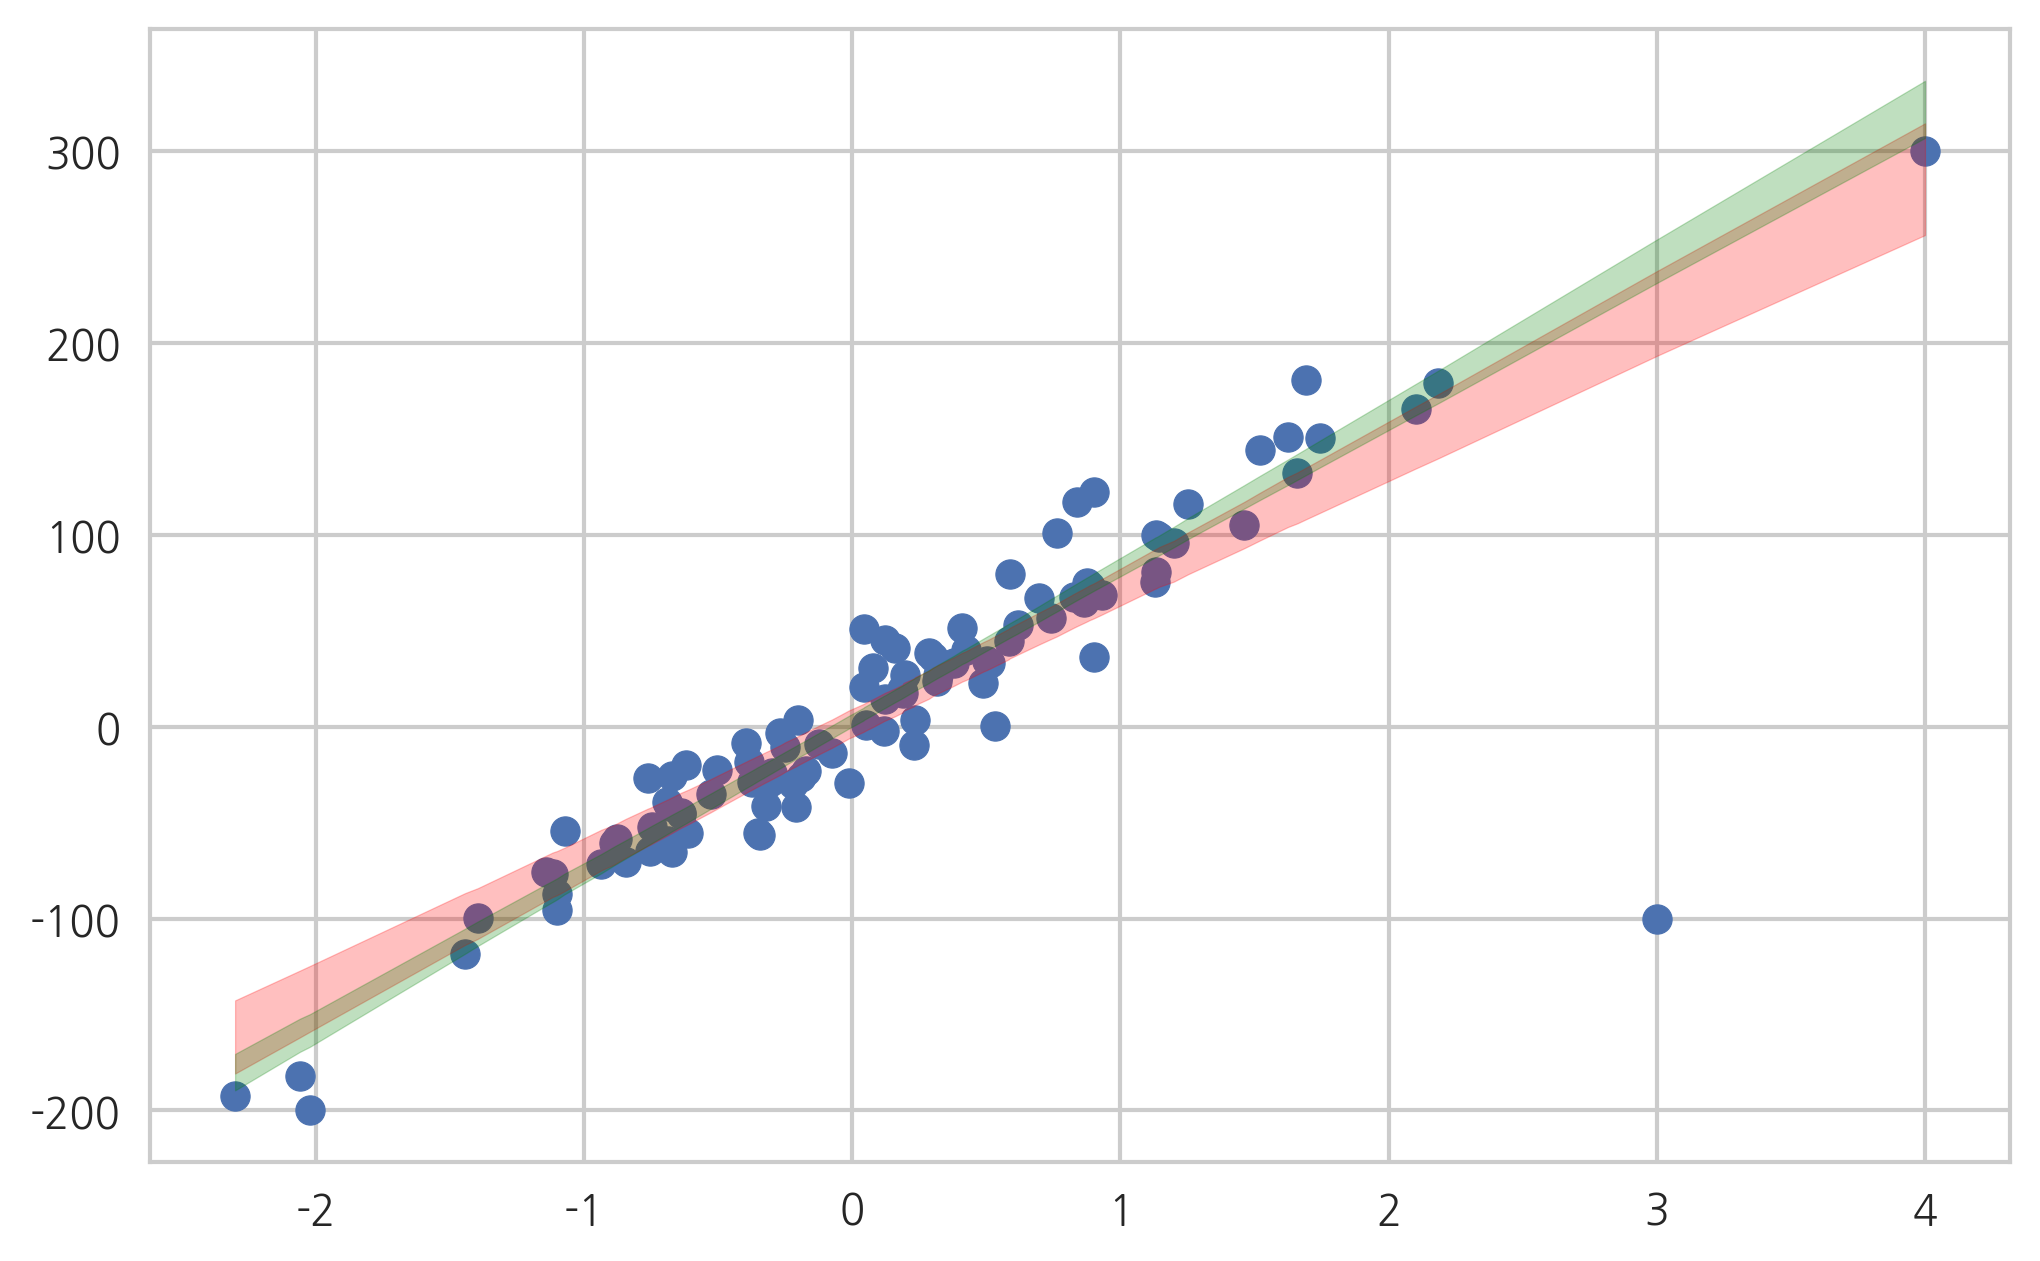

In [45]:
ids = np.argsort(x)
confint1 = pm.df_summary(trace1)[['hpd_2.5', 'hpd_97.5']]['mu__0':'mu__101'].values
confint2 = pm.df_summary(trace2)[['hpd_2.5', 'hpd_97.5']]['mu__0':'mu__101'].values

plt.scatter(x, y_data)
plt.fill_between(x[ids], confint1[ids, 0], confint1[ids, 1], color='red', alpha=0.25)
plt.fill_between(x[ids], confint2[ids, 0], confint2[ids, 1], color='green', alpha=0.25)
plt.show()